### Packages

In [1]:
# cd /project/3022057.01/IFA
# module load anaconda3
# source activate IFAenv
# jupyter notebook --no-browser --ip=* --port=8888 --NotebookApp.token=''

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.signal import sawtooth
from scipy.linalg import svdvals
from sklearn.decomposition import FastICA, PCA
from sklearn.manifold import MDS, TSNE
import umap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC, LinearSVC
from sklearn.covariance import LedoitWolf
from sklearn.linear_model import LogisticRegression, LinearRegression, MultiTaskLasso, Lasso, LassoCV, ElasticNet, MultiTaskLassoCV
from sklearn.metrics.pairwise import cosine_similarity
from nilearn import plotting as nplot
from nilearn import image as nimg
from nilearn import datasets, plotting
from nilearn.regions import connected_label_regions
from nilearn import input_data
from nilearn import image as nimg
from nilearn.connectome import ConnectivityMeasure
from pyriemann.estimation import Covariances
from pyriemann.utils.mean import mean_covariance
from pyriemann.utils.tangentspace import tangent_space, untangent_space, log_map_riemann, unupper
from pyriemann.utils.distance import distance_riemann
from pyriemann.utils.base import logm
from pyriemann.utils.distance import distance
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import seaborn as sns
import torch

### Options

In [2]:
Tangent_Class = False
Tangent_CSP = False
riem_filters = True
all_subs = True
concatenate_spatial_bases = True
# Pyriemannian Mean https://github.com/pyRiemann/pyRiemann/blob/master/pyriemann/utils/mean.py#L633 Metric for mean estimation, can be: "ale", "alm", "euclid", "harmonic", "identity", "kullback_sym", "logdet", "logeuclid", "riemann", "wasserstein", or a callable function.
# https://link.springer.com/article/10.1007/s12021-020-09473-9 <---- best descriptions/plots
# Geometric means in a novel vector space structure on symmetric positive-definite matrices <https://epubs.siam.org/doi/abs/10.1137/050637996?journalCode=sjmael>`_
metric = "logeuclid"

### Memory and Processor Usage/Limits Checks

In [ ]:
# https://www.kernel.org/doc/Documentation/cgroup-v1/memory.txt
#Open terminal for job
# srun --jobid=68974 --overlap --pty /bin/bash 

# #SLURM RAM
# !cgget -r memory.limit_in_bytes /slurm/uid_$SLURM_JOB_UID/job_$SLURM_JOB_ID

# #SLURM VM
# !cgget -r memory.memsw.limit_in_bytes /slurm/uid_$SLURM_JOB_UID/job_$SLURM_JOB_ID

# #SLURM USAGE
# !cgget -r memory.memsw.usage_in_bytes /slurm/uid_$SLURM_JOB_UID/job_$SLURM_JOB_ID

#TORQUE Virtual Memory
!cgget -r memory.memsw.limit_in_bytes /torque/$PBS_JOBID

#TORQUE RAM
!cgget -r memory.limit_in_bytes /torque/$PBS_JOBID

#TORQUE USAGE
!cgget -r memory.memsw.usage_in_bytes /torque/$PBS_JOBID


In [ ]:
print(int(os.environ['PBS_NP']))

### MELODIC Model Order Converted

In [ ]:
from scipy.special import loggamma

def iFeta(eta, d1, d2):
    # Calculate Survival Function (Probability an eigenvalue from a random guassian matrix is > some value (defined by bounds))
    # Multiplying the survival function by d1  scales these probabilities to estimate how many of these eigenvalues are greater than a given value
    res = d1 * (1.0 - Feta(eta, d1 / d2))
    plt.scatter(eta,res)
    plt.show()

    result = np.zeros(d1)
    # Finds value of eigenvalue in each quartile
    for k in range(d1):
        idx = np.max(np.where(res >= (k + 1)))
        result[k] = eta[idx]
    plt.scatter(range(0,d1),result)
    plt.show()
    return result

def Feta(eta, y, sig2=1.0):
    # https://ieeexplore.ieee.org/abstract/document/847792/authors#authors
    # Calculate bounds of marchenk-pastuur/wishart
    bm = sig2 * (1.0 - np.sqrt(y)) ** 2
    bp = sig2 * (1.0 + np.sqrt(y)) ** 2
    result = np.zeros_like(eta)
    # Calculate PDF Wishart/Marchenko Pastuur
    teta = np.arange(bm, bp, 0.001)
    feta = ((2 * np.pi * y * teta) ** (-1)) * np.sqrt((teta - bm) * (bp - teta))
    plt.scatter(teta,feta)
    plt.show()
    tmp = (np.outer(teta, np.ones(eta.shape[0])) / eta) < 1
    # Calculate PDF (Probability an eigenvalue from a random guassian matrix is < some value (defined by bounds))
    result = np.sum((0.001 * np.outer(feta, np.ones(eta.shape[0]))) * tmp, axis=0)
    plt.scatter(eta,result)
    plt.show()

    return result

def adj_eigspec(eigenvalues, n):
    # eigenspectrum assumed to be sorted
    # Calculate CircleLaw using Feta function
    CircleLaw = iFeta(np.arange(0.001, 4.00, 0.001), eigenvalues.shape[0], n)
    
    # Adjust eigenvalues by CircleLaw
    AdjEV = eigenvalues * CircleLaw**-1
    
    # Normalize AdjEV to the range [0, 1]
    # AdjEV = (AdjEV - np.min(AdjEV)) / (np.max(AdjEV) - np.min(AdjEV))
    
    return AdjEV

def ppca_est_laplace(eigenvalues, N):
    """
    Estimate the dimensionality of the data using Laplace's method.

    Parameters:
    eigenvalues (numpy.ndarray): The eigenvalues of the covariance matrix. Assumed in descendening order
    N (int): The number of data points.

    Returns:
    int: The estimated dimensionality.
    """
    d = len(eigenvalues)
    log_lambda = np.log(eigenvalues)
    
    # TODO should I consider or remove the last value
    k = np.arange(1, d+1)
    m = d * k - 0.5 * k * (k + 1)
    
    l_prob_U = -k*np.log(2) + np.cumsum(loggamma((d-k+1)/2) - ((d-k+1)/2)*np.log(np.pi))


    l_lam = (-N/2)*np.cumsum(log_lambda)
    
    l_nu = np.zeros(d)
    # TODO make more efficient and parallelize
    # nu_numerator = (np.cumsum(k[::-1]) - k[::-1])[::-1]
    # l_nu[:-1] = np.log(nu_numerator[:-1]/(d-k[:-1]))
    for i in range(0,d-1):
        l_nu[i] = np.log(np.mean(eigenvalues[i:]))
    temp_l_nu = np.copy(l_nu)
    l_nu = ((-N*(d-k))/2)*l_nu

    l_pi_term = ((m+k)/2)*np.log(2*np.pi)

    # TODO Can parallelize this as well by building upper triangular matrices but not as necessary since we are not in python
    # TODO Why did Christian drop the N term and use 0.5 instead of -.5
    # TODO Make more efficient and don't initialize with zeors
    l_Az  = np.zeros(d)
    for i in range(0,d):
        li = eigenvalues[i]
        lj_hat = temp_l_nu[i]
        Az_k = 0
        for j in range(i+1,d):
            lj = eigenvalues[j]
            inv_term = (lj_hat**-1 - li**-1)
            inv_term = np.log(inv_term) if inv_term > 0 else 0
            l_term = li-lj
            l_term = np.log(l_term) if l_term > 0 else 0
            Az_k += inv_term + l_term + np.log(N)
        l_Az[i] = Az_k
    l_Az = -0.5*l_Az

    l_N_term = (-(k)/2)*np.log(N)
    
    l_lap = (l_prob_U + l_lam + l_nu + l_pi_term + l_Az + l_N_term)
    # l_lap = (l_lam + l_nu + l_N_term)
    
    plt.figure()
    plt.scatter(range(0,d), l_nu, label='l_nu')
    plt.legend()
    plt.show()

    plt.figure()
    plt.scatter(range(0,d), temp_l_nu, label='average log noise')
    plt.legend()
    plt.show()

    plt.figure()
    plt.scatter(range(0,d), l_pi_term, label='l_pi_term')
    plt.legend()
    plt.show()

    plt.figure()
    plt.scatter(range(0,d), l_Az, label='l_Az')
    plt.legend()
    plt.show()

    plt.figure()
    plt.scatter(range(0,d), log_lambda, label='log eigs')
    plt.legend()
    plt.show()

    plt.figure()
    plt.scatter(range(0,d), l_lam, label='l_lam')
    plt.legend()
    plt.show()

    plt.figure()
    plt.scatter(range(0,d), l_N_term, label='l_N_term')
    plt.legend()
    plt.show()

    plt.figure()
    plt.scatter(range(0,d),l_lap, label='l_lap', marker='x')
    plt.legend()
    plt.show()


    estimated_dim = np.argmax(l_lap) + 1
    return estimated_dim

def run_pca_and_estimate_components(X):
    # Run PCA
    n_samples, n_features = X.shape
    X_standardized = (X - np.mean(X, axis=0))
    U,s,Vh = np.linalg.svd(X_standardized, full_matrices=False)
    eigenvalues = (s**2)/n_samples
    # Adjust eigenvalues
    adjusted_eigenvalues = adj_eigspec(eigenvalues, n_samples)

    # # Estimate number of components using Laplace method
    estimated_components = ppca_est_laplace(adjusted_eigenvalues, n_samples)

    # # Rebuild X using the adjusted eigenvalues
    # adjusted_s = np.sqrt(adjusted_eigenvalues*n_samples)
    # X_rebuilt = U@np.diag(adjusted_s)@Vh

    # # Standardize the rebuilt X
    # X_rebuilt_standardized = (X_rebuilt - np.mean(X_rebuilt, axis=0))


    # # Run PCA with n_components="mle"
    # pca = PCA(n_components="mle")
    # pca.fit(X_rebuilt_standardized)
    # estimated_components = pca.n_components_
    # adjusted_eigs = pca.explained_variance_
    
    # Create scree plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'o-', label='Eigenvalues')
    plt.plot(range(1, len(adjusted_eigenvalues) + 1), adjusted_eigenvalues, 'o-', label='Eigenvalues')
    plt.axvline(x=estimated_components, color='r', linestyle='--', label=f'Estimated Components: {estimated_components}')
    plt.title('Scree Plot with Laplace Score')
    plt.xlabel('Component Number')
    plt.ylabel('Eigenvalue')
    plt.legend()
    plt.show()

    return U[:, :estimated_components]

### MELODIC Model Order Selection Direct Call Matlab

In [ ]:
import matlab.engine

def call_pca_dim(Data=None,eigs=None,N=None):
   # Start MATLAB engine
    eng = matlab.engine.start_matlab()
    
    # Add the path to the MATLAB function
    eng.addpath("/project/3022057.01/IFA/melodic", nargout=0)
    
    if Data is not None:
      # Call the MATLAB function
      prob = eng.pca_dim(matlab.double(Data))
      eig_vectors = np.array(prob['E'])
    else:
      prob = eng.pca_dim_eigs(matlab.double(eigs),matlab.double(N))

    # Extract and convert each variable
    lap = np.array(prob['lap']).flatten().reshape(-1, 1)
    bic = np.array(prob['bic']).flatten().reshape(-1, 1)
    rrn = np.array(prob['rrn']).flatten().reshape(-1, 1)
    AIC = np.array(prob['AIC']).flatten().reshape(-1, 1)
    MDL = np.array(prob['MDL']).flatten().reshape(-1, 1)
    eig = np.array(prob['eig']).flatten()
    orig_eig = np.array(prob['orig_eig']).flatten()
    leig = np.array(prob['leig']).flatten()

    # Stop MATLAB engine
    eng.eval('clearvars', nargout=0)
    eng.quit()
    
    plt.figure(figsize=(10, 6))
    plt.scatter(np.arange(len(eig)),eig,label="Adjusted Eigenspectrum")
    plt.scatter(np.arange(len(orig_eig)),orig_eig,label="Eigenspectrum")
    plt.xlabel('Index')
    plt.ylabel('Eigenvalue')
    plt.legend()
    plt.title('Scree Plot')
    plt.show()


    # Use SimpleImputer to handle any missing values
    imputer = SimpleImputer(strategy='mean')
    lap = imputer.fit_transform(lap)
    bic = imputer.fit_transform(bic)
    rrn = imputer.fit_transform(rrn)
    AIC = imputer.fit_transform(AIC)
    MDL = imputer.fit_transform(MDL)
    
    # Use StandardScaler to standardize the data
    scaler = StandardScaler()
    lap_std = scaler.fit_transform(lap)
    bic_std = scaler.fit_transform(bic)
    rrn_std = scaler.fit_transform(rrn)
    AIC_std = scaler.fit_transform(AIC)
    MDL_std = scaler.fit_transform(MDL)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.scatter(np.arange(len(lap_std)), lap_std, label='Laplacian')
    plt.scatter(np.arange(len(bic_std)), bic_std, label='BIC')
    plt.scatter(np.arange(len(rrn_std)), rrn_std, label='RRN')
    plt.scatter(np.arange(len(AIC_std)), AIC_std, label='AIC')
    plt.scatter(np.arange(len(MDL_std)), MDL_std, label='MDL')
    
    plt.xlabel('Index')
    plt.ylabel('Standardized Value')
    plt.legend()
    plt.title('Scatter Plot of Standardized Eigenvalues and Model Order Selection Values')
    plt.show()
   
    return np.argmax(rrn_std)+1


### Load Atlas & Create Mask

Number of Labels in Mask:  360


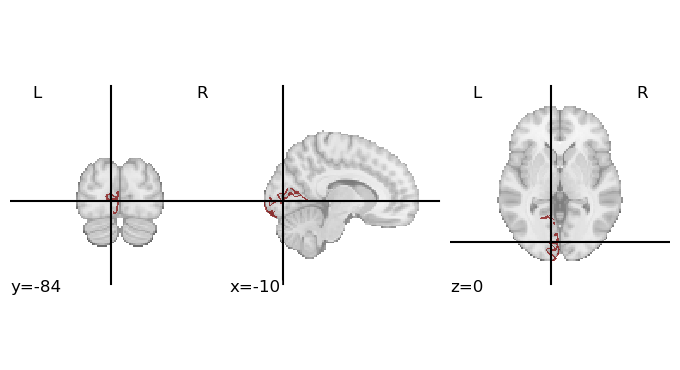

In [3]:
# Parcellation and Atlas References:
    # https://dartbrains.org/content/Parcellations.html#summary-of-differences-between-parcellations
    # https://nipy.org/nibabel/nibabel_images.html
    # https://nilearn.github.io/dev/auto_examples/03_connectivity/plot_signal_extraction.html
    # https://nilearn.github.io/dev/modules/generated/nilearn.regions.Parcellations.html
    # https://dartbrains.org/content/Parcellations.html#nilearn
    # https://carpentries-incubator.github.io/SDC-BIDS-fMRI/aio/index.html

def create_mask(dir='../resources/rois/', n_rois=200, yeo_networks=17, resolution_mm=1):
    """
    Create a brain mask using the Schaefer atlas or a provided directory.
    
    Parameters:
    dir (str): Directory to fetch or load atlas data from.
    n_rois (int): Number of regions of interest.
    yeo_networks (int): Number of Yeo networks.
    resolution_mm (int): Resolution in millimeters.

    Returns:
    tuple: NiftiLabelsMasker object, atlas image, and region labels.
    """
    if dir == '../resources/rois/':
        parcel_dir = dir
        schaefer = datasets.fetch_atlas_schaefer_2018(n_rois, yeo_networks, resolution_mm, data_dir=parcel_dir)
        atlas_schaefer = schaefer['maps']
        atlas = connected_label_regions(atlas_schaefer)
    else:
        atlas = dir

    masker = input_data.NiftiLabelsMasker(labels_img=atlas, standardize=True)
    atlas_img = nimg.load_img(atlas)
    region_labels = np.unique(atlas_img.get_fdata())
    region_labels = np.setdiff1d(region_labels, [0])  # Remove the background label (0)

    return masker, atlas, region_labels

def view_labels(atlas, roi='a == 1'):
    """
    View the labels of the atlas for a specified region of interest (ROI).
    
    Parameters:
    atlas (Nifti1Image): Atlas image.
    roi (str): Mathematical expression to specify the ROI.

    """
    roi_mask = nimg.math_img(roi, a=atlas)
    nplot.plot_roi(roi_mask, cmap='jet')

# fine_ICP = "/project/3022057.01/resources/rois/ICPAtlas_v4_fine_208parcels.nii.gz"
# course_ICP = "/project/3022057.01/resources/rois/ICPAtlas_v4_coarse_79parcels.nii.gz"  # Uncomment this, comment above, and change below for course ICP
glasser = "/project/3022057.01/resources/rois/MMP_in_MNI_corr.nii.gz"
mask, atlas, region_labels = create_mask(glasser)
print("Number of Labels in Mask: ", len(region_labels))
view_labels(atlas)

### DONT RUN (Unless Subjects Are Not Parcellated) Load and Parcellate Subjects (REVIST INCOMPLETE)

In [ ]:
def load(n=0, folder1=0, folder2=-1, parcellated_directory="/project/3022057.01/icp_parcellated_subs"):
    """
    Load data for a specified number of subjects and fMRI tasks, only if they have not been parcellated.

    Parameters:
    n (int): Number of subjects to load (default is 0).
    folder1 (int): Index of the first fMRI task folder (default is 0).
    folder2 (int): Index of the second fMRI task folder, if any (default is -1).
    parcellated_directory (str): The directory where parcellated data is stored.

    Returns:
    list: A list of tuples containing paths to the subject data files.
    """
    # Min and max number of subjects
    if n < 0:
        n = 0
    elif n > 1113:
        n = 1113

    # Define the directory where the data is stored
    base_directory = "/project_cephfs/3022017.01/S1200"
    subdirectory = "MNINonLinear/Results"
    
    # Define the list of folders for rfMRI and tfMRI
    folders = [
        "rfMRI_REST1_LR", "rfMRI_REST1_RL", "rfMRI_REST2_LR", "rfMRI_REST2_RL",
        "tfMRI_EMOTION_LR", "tfMRI_EMOTION_RL", "tfMRI_GAMBLING_LR", "tfMRI_GAMBLING_RL",
        "tfMRI_LANGUAGE_LR", "tfMRI_LANGUAGE_RL", "tfMRI_MOTOR_LR", "tfMRI_MOTOR_RL",
        "tfMRI_RELATIONAL_LR", "tfMRI_RELATIONAL_RL", "tfMRI_SOCIAL_LR", "tfMRI_SOCIAL_RL",
        "tfMRI_WM_LR", "tfMRI_WM_RL"
    ]
    
    # Randomly select n subjects without repetition
    selected_subjects = set()
    subjects = os.listdir(base_directory)
    while len(selected_subjects) < n:
        subject = random.choice(subjects)
        subject_data1 = os.path.join(base_directory, subject, subdirectory, folders[folder1], folders[folder1] + ".nii.gz")

        # Determine the output directory and file name for the parcellated data
        subdir = subject
        taskdir = folders[folder1]
        parcellated_file = os.path.join(parcellated_directory, subdir, f"{taskdir}_parcellated.npy")
        # Check if the parcellated file does not exist and if the original file exists
        if not os.path.exists(parcellated_file) and os.path.exists(subject_data1):
            if folder2 >= 0:
                subject_data2 = os.path.join(base_directory, subject, subdirectory, folders[folder2], folders[folder2] + ".nii.gz")
                parcellated_file2 = os.path.join(parcellated_directory, subdir, f"{folders[folder2]}_parcellated.npy")
                # Check if the second file exists and is not parcellated before adding it
                if not os.path.exists(parcellated_file2) and os.path.exists(subject_data2):
                    selected_subjects.add((subject_data1, subject_data2))
            else:
                selected_subjects.add((subject_data1,))

    return [list(sub) for sub in selected_subjects]

def parcellate(sub_data, masker, region_labels, verbose=False):
    """
    Parcellate fMRI data into regions of interest.

    Parameters:
    sub_data (Nifti1Image): The fMRI data to be parcellated.
    masker: The masker object used for parcellation.
    region_labels (list): List of region labels for the parcellation.
    verbose (bool): If True, print additional information (default is False).

    Returns:
    np.ndarray: The parcellated fMRI data.
    """
    # Create parcellated data
    parcellated = masker.fit_transform(sub_data)
    num_labels = len(region_labels)
    
    # Number of timepoints
    num_timepoints = sub_data.shape[3]
    # Create an array of zeros that has the correct size
    final_signal = np.zeros((num_timepoints, num_labels))

    # Get regions that are kept
    regions_kept = np.array(masker.labels_, dtype='int')

    # Fill columns matching labels with signal values
    final_signal[:, regions_kept-1] = parcellated
    if verbose:
        print("Number of atlas labels: ", num_labels)
        print("Number of parcellated labels: ", len(masker.labels_))
        print("Missing labels: ", set(region_labels) - set(np.unique(masker.labels_)))
    return final_signal

def parcellate_all(allsubs, mask, region_labels, save=False, verbose=False, location=''):
    """
    Parcellate data for all subjects and tasks, and optionally save the results.

    Parameters:
    allsubs (list): List of subject data paths.
    mask: The masker object used for parcellation.
    region_labels (list): List of region labels for the parcellation.
    save (bool): If True, save the parcellated data (default is False).
    verbose (bool): If True, print additional information (default is False).
    location (str): The directory location to save the parcellated data (default is '').

    Returns:
    list: List of parcellated data arrays for all subjects and tasks.
    """
    main_output_directory = os.path.normpath(r"/project/3022057.01/")

    alldata = []
    for sub in allsubs:
        for task in sub:
            if verbose:
                print(task)
            sub_data = nimg.load_img(task)
            parcellated = parcellate(sub_data, mask, region_labels, verbose=verbose)
            alldata.append(parcellated)
            if save:
                subdir = task[task.find("S1200") + len("S1200"):].split("/")[1]
                taskdir = task[task.find("Results") + len("Results"):].split("/")[1]
                sub_output_directory = os.path.join(main_output_directory, location, subdir)
                os.makedirs(sub_output_directory, exist_ok=True)
                output_filename = os.path.join(sub_output_directory, f"{taskdir}_parcellated.npy")
                if verbose:
                    print(output_filename)
                np.save(output_filename, parcellated)
    return alldata

n = 500
folder1 = 8
folder2 = 10

allsubs = load(n, folder1, folder2)
print(allsubs)
alldata = parcellate_all(allsubs, mask, region_labels, save=True, verbose=True, location="icp_parcellated_subs")

### Load and or Simulate Data (REVIST INCOMPLETE)

TODO Time Series Checks and Paths Hardcoded

In [4]:
def create_signal(samples, parcels, sig_freqA=0.03, sig_freqB=0.05, spatial_ratio=0.1, signal_type="saw", visualize=False):
    """
    Create and add signal to a random subset of parcels.

    Parameters:
    samples (int): Number of samples.
    parcels (int): Number of parcels.
    sig_freqA (float): Frequency of the signal for group A.
    sig_freqB (float): Frequency of the signal for group B.
    spatial_ratio (float): Ratio of parcels to add the signal.
    signal_type (str): Type of the signal, 'saw' or 'sin'.
    visualize (bool): Whether to visualize the signals and heatmaps.

    Returns:
    tuple: groupA_signal, groupB_signal, groupA_parcels, groupB_parcels
    """
    
    num_parcels_with_signal = int(spatial_ratio * parcels)
    groupA_parcels = np.random.choice(parcels, size=num_parcels_with_signal, replace=False)
    groupB_parcels = np.random.choice(np.setdiff1d(np.arange(parcels), groupA_parcels), size=num_parcels_with_signal, replace=False)

    x = np.linspace(0, samples, num=samples)
    if signal_type == "sin":
        groupA_signal = np.sin(sig_freqA * x)
        groupB_signal = sawtooth(sig_freqB * x)
    else:
        groupA_signal = sawtooth(sig_freqA * x)
        groupB_signal = np.sin(sig_freqB * x)

    groupA_signal = (groupA_signal - np.mean(groupA_signal)) / np.std(groupA_signal)
    groupB_signal = (groupB_signal - np.mean(groupB_signal)) / np.std(groupB_signal)

    parcelsA = np.zeros((samples, parcels))
    parcelsB = np.zeros((samples, parcels))

    parcelsA[:, groupA_parcels] += np.reshape(groupA_signal, (-1, 1))
    parcelsB[:, groupB_parcels] += np.reshape(groupB_signal, (-1, 1))

    if visualize:
        plt.figure(figsize=(12, 12))
        plt.subplot(3, 1, 1)
        plt.imshow(parcelsA.T, aspect='auto', cmap='viridis', origin='lower')
        plt.colorbar(label='Amplitude')
        plt.title('Heatmap of Generated Group A fMRI Matrix')
        plt.xlabel('Samples')
        plt.ylabel('Parcels')
        
        plt.subplot(3, 1, 2)
        plt.imshow(parcelsB.T, aspect='auto', cmap='viridis', origin='lower')
        plt.colorbar(label='Amplitude')
        plt.title('Heatmap of Generated Group B fMRI Matrix')
        plt.xlabel('Samples')
        plt.ylabel('Parcels')

        plt.subplot(3, 1, 3)
        plt.plot(groupA_signal, label="Group A Signal")
        plt.plot(groupB_signal, label="Group B Signal")
        plt.title('Signal in Selected Parcels')
        plt.legend()
        plt.xlabel('Samples')
        plt.ylabel('Amplitude')
        plt.tight_layout()
        plt.show()

    return groupA_signal, groupB_signal, groupA_parcels, groupB_parcels

def simulate_data(allsubs_data, sig_freqA=0.03, sig_freqB=0.5, spatial_ratio=0.01, sub_ratio=0.5, original_level=0.5, simulateA=True, simulateB=True):
    """
    Simulate data by adding signals to a subset of subjects.

    Parameters:
    allsubs_data (numpy.ndarray): Array of all subjects' data.
    sig_freqA (float): Frequency of the signal for group A.
    sig_freqB (float): Frequency of the signal for group B.
    spatial_ratio (float): Ratio of parcels to add the signal.
    sub_ratio (float): Ratio of subjects to add the signal.
    original_level (float): Weight of the original signal.
    simulateA (bool): Whether to simulate data for group A.
    simulateB (bool): Whether to simulate data for group B.

    Returns:
    tuple: groupA_data, groupB_data, groupA_parcels, groupB_parcels
    """
    
    samples = allsubs_data[0].shape[0]
    parcels = allsubs_data[0].shape[1]
    groupA_signal, groupB_signal, groupA_parcels, groupB_parcels = create_signal(samples, parcels, sig_freqA=sig_freqA, sig_freqB=sig_freqB, spatial_ratio=spatial_ratio, signal_type="saw", visualize=True)

    nsubjects = len(allsubs_data)
    nsubjects_semi_simulated = int(nsubjects * sub_ratio)

    selected_subjects = np.random.choice(nsubjects, size=nsubjects_semi_simulated, replace=False)
    unselected_subjects = np.setdiff1d(np.arange(nsubjects), selected_subjects)

    groupA_data = allsubs_data[selected_subjects, :, :].copy()
    groupB_data = allsubs_data[unselected_subjects, :, :].copy()
    
    if simulateA:
        for i, subject in enumerate(groupA_data):
            for parcel in groupA_parcels:
                subjectA_signal = (subject[:, parcel] - np.mean(subject[:, parcel])) / np.std(subject[:, parcel])
                groupA_data[i, :, parcel] = np.sqrt(original_level) * subjectA_signal + np.sqrt(1 - original_level) * groupA_signal

    if simulateB:
        for i, subject in enumerate(groupB_data):
            for parcel in groupB_parcels:
                subjectB_signal = (subject[:, parcel] - np.mean(subject[:, parcel])) / np.std(subject[:, parcel])
                groupB_data[i, :, parcel] = np.sqrt(original_level) * subjectB_signal + np.sqrt(1 - original_level) * groupB_signal

    return groupA_data, groupB_data, groupA_parcels, groupB_parcels

def visualize_semi_simulated_subject(groupA_data, groupB_data):
    """
    Visualize the semi-simulated subjects' data.

    Parameters:
    groupA_data (numpy.ndarray): Simulated data for group A.
    groupB_data (numpy.ndarray): Simulated data for group B.
    """
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

    axes[0, 0].plot(groupA_data[0, :, :])
    axes[0, 0].set_title('Group A Subject 0 Time Series')
    axes[0, 0].set_xlabel('Samples')
    axes[0, 0].set_ylabel('Amplitude')

    axes[0, 1].plot(groupB_data[0, :, :])
    axes[0, 1].set_title('Group B Subject 0 Time Series')
    axes[0, 1].set_xlabel('Samples')
    axes[0, 1].set_ylabel('Amplitude')

    img = axes[1, 0].imshow(groupA_data[0, :, :].T, aspect='auto', cmap='viridis', origin='lower')
    cbar = plt.colorbar(img, ax=axes[1, 0])
    cbar.set_label('Amplitude')
    axes[1, 0].set_title('Group A Subject 0 Parcelated Data')
    axes[1, 0].set_xlabel('Samples')
    axes[1, 0].set_ylabel('Parcels')
    
    img = axes[1, 1].imshow(groupB_data[0, :, :].T, aspect='auto', cmap='viridis', origin='lower')
    cbar = plt.colorbar(img, ax=axes[1, 1])
    cbar.set_label('Amplitude')
    axes[1, 1].set_title('Group B Subject 0 Parcelated Data')
    axes[1, 1].set_xlabel('Samples')
    axes[1, 1].set_ylabel('Parcels')

    plt.tight_layout()
    plt.show()



# subjects_path = r'/project/3022057.01/glasser_parcellated_subs'
# subjects_path = r'/project/3022057.01/icp_parcellated_subs'

# groupA_data = []
# groupB_data = []
# groupA_type = "REST"
# groupB_type = "MOTOR"
# simulate = False
# n_subs = 500

# if simulate:
#     allsubs_data = []
#     for subdir, dirs, files in os.walk(subjects_path):
#         for file in files:
#             if groupA_type in file:
#                 sub_data = np.load(os.path.join(subdir,file))
#                 if sub_data.shape[0] == 1200:
#                     allsubs_data.append(sub_data)
#     allsubs_data = np.array(allsubs_data)
#     groupA_data, groupB_data, groupA_parcels, groupB_parcels = simulate_data(allsubs_data, sig_freqA=.05,sig_freqB=.027, spatial_ratio=.01, sub_ratio=.5, original_level=0.8, simulateA=True, simulateB=True)
# else:
#     for subdir, dirs, files in os.walk(subjects_path):
#         for file in files:
#             # if len(groupA_data) >= n_subs and len(groupB_data) >= n_subs:
#                 # break
#             if groupA_type in file:
#                 sub_data = np.load(os.path.join(subdir,file))
#                 # if sub_data.shape[0] == 1200*4:
#                 groupA_data.append(sub_data)
# #             elif (groupB_type in file):
# #                 sub_data = np.load(os.path.join(subdir,file))
# #                 if sub_data.shape[0] == 568:
# #                     groupB_data.append(sub_data)
# print(len(groupA_data))
# # groupA_data = np.array(groupA_data)
# # groupB_data = np.array(groupB_data)

# # visualize_semi_simulated_subject(groupA_data, groupB_data)

In [ ]:
import re
import pandas as pd

def load_data(paths):
    data_list = []
    reference_shape = None
    reference_dtype = None

    for path in paths:
        data = np.load(path)
        
        # Check if the data has the same shape as the reference
        if reference_shape is None:
            reference_shape = data.shape
        if reference_dtype is None:
            reference_dtype = data.dtype
        
        if data.shape != reference_shape:
            print(f"Skipping {path}: shape {data.shape} does not match reference shape {reference_shape}.")
            continue
        
        if data.dtype != reference_dtype:
            print(f"Skipping {path}: dtype {data.dtype} does not match reference dtype {reference_dtype}.")
            continue
        
        data_list.append(data)
    
    return np.array(data_list)
    
def select_subs(group_type="WM", VOI='PSQI_Comp6', threshold1=0,threshold2=0):
    pathnames = []
    # File paths
    file_path_restricted = r'../HCP/RESTRICTED_zainsou_8_6_2024_2_11_21.csv'
    file_path_unrestricted = r'../HCP/unrestricted_zainsou_8_2_2024_6_13_22.csv'

    try:
        # Load the data from CSV files
        data_r = pd.read_csv(file_path_restricted)
        data_ur = pd.read_csv(file_path_unrestricted)
        print("Files loaded successfully.")
    except FileNotFoundError:
        print(f"File not found: {file_path_restricted} or {file_path_unrestricted}")
        raise

    # Combine restricted and unrestricted data on Subject ID
    data = pd.merge(data_r, data_ur, on='Subject', how='outer')


    for subdir, dirs, files in os.walk(subjects_path):
        for file in files:
                if group_type in file:
                    # if np.load(os.path.join(subdir,file)).shape[0] == 316*2:
                    pathnames.append(os.path.join(subdir,file))    
    
    # Extract subids from the pathnames
    subids = [re.search(r'/(\d+)/', path).group(1) for path in pathnames]
    # Filter the data to include only subjects with subids in the extracted list
    filtered_data = data[data['Subject'].astype(str).isin(subids)]

    # picvocab_low_threshold = filtered_data["PicVocab_AgeAdj"].quantile(.1)
    # picvocab_high_threshold = filtered_data["PicVocab_AgeAdj"].quantile(0.9)

    pmat24_low_threshold = filtered_data["PMAT24_A_CR"].quantile(.1)
    pmat24_high_threshold = filtered_data["PMAT24_A_CR"].quantile(.9)

    # ssaga_educ_low_threshold = filtered_data["SSAGA_Educ"].quantile(.3)
    # ssaga_educ_high_threshold = filtered_data["SSAGA_Educ"].quantile(.7)

    # lifesatisf_low_threshold = filtered_data["LifeSatisf_Unadj"].quantile(.3)
    # lifesatisf_high_threshold = filtered_data["LifeSatisf_Unadj"].quantile(.7)

    # psqi_low_threshold = filtered_data["PSQI_Score"].quantile(.5)
    # psqi_high_threshold = filtered_data["PSQI_Score"].quantile(.5)

    # tobacco_low_threshold = 10
    # tobacco_high_threshold = 0

    # # Binary variables - set the thresholds manually
    # fam_hist_threshold_high = 0
    # fam_hist_threshold_low = 1

    # thc_threshold_high = 0
    # thc_threshold_low = 1

    # Filtering Group 1 (high tail) and Group 2 (low tail)
    group_1 = filtered_data[
        # (filtered_data["PicVocab_AgeAdj"] >= picvocab_high_threshold) &
        (filtered_data["PMAT24_A_CR"] >= pmat24_high_threshold) & 1
        # (filtered_data["SSAGA_Educ"] >= ssaga_educ_high_threshold) & 
        # (filtered_data["LifeSatisf_Unadj"] >= lifesatisf_high_threshold) & 
        # (filtered_data["PSQI_Score"] <= psqi_high_threshold) &
        # (filtered_data["Total_Any_Tobacco_7days"] <= tobacco_high_threshold) & 
        # (filtered_data["FamHist_Fath_DrgAlc"] == fam_hist_threshold_high) &
        # (filtered_data["THC"] == thc_threshold_high)
    ]

    group_2 = filtered_data[
        # (filtered_data["PicVocab_AgeAdj"] <= picvocab_low_threshold) &
        (filtered_data["PMAT24_A_CR"] <= pmat24_low_threshold) & 1
        # (filtered_data["SSAGA_Educ"] <= ssaga_educ_low_threshold) & 
        # (filtered_data["LifeSatisf_Unadj"] <= lifesatisf_low_threshold) & 
        # (filtered_data["PSQI_Score"] >= psqi_low_threshold) & 
        # (filtered_data["Total_Any_Tobacco_7days"] >= tobacco_low_threshold) & 
        # (filtered_data["FamHist_Fath_DrgAlc"] == fam_hist_threshold_low) & 
        # (filtered_data["THC"] == thc_threshold_low)
    ]

    # Print the number of subjects in each group
    print(f"Group 1 (high tail): {len(group_1)} subjects")
    print(f"Group 2 (low tail): {len(group_2)} subjects")

    # Optionally, visualize the filtered groups
    plt.figure(figsize=(10, 6))
    plt.hist(group_1["PMAT24_A_CR"], bins=30, alpha=0.7, label='Group 1 (High Tail)')
    plt.hist(group_2["PMAT24_A_CR"], bins=30, alpha=0.7, label='Group 2 (Low Tail)')
    plt.xlabel('PMAT24_A_CR')
    plt.ylabel('Number of Subjects')
    plt.title(f'Distribution of PMAT24_A_CR for {group_type} Subjects in Group 1 and Group 2')
    plt.legend()
    plt.show()

    # # Filter the  values into two groups
    # # group_1 = filtered_data[filtered_data[VOI].isin(threshold1)]
    # # group_2 = filtered_data[filtered_data[VOI].isin(threshold2)]
    # # group_1 = filtered_data[filtered_data[VOI] >= (threshold1)]
    # # group_2 = filtered_data[filtered_data[VOI] <= (threshold2)]

    # group_1 = filtered_data[filtered_data["PicVocab_AgeAdj"] >= 130 ...]
    # group_2 = filtered_data[filtered_data["PicVocab_AgeAdj"] <= 90 ...]
    # print("Group 1", len(group_1), "Group 2", len(group_2))

    # # Plot the distribution of subjects in each group
    # plt.figure(figsize=(10, 6))
    # plt.hist(group_1[VOI], bins=60, alpha=0.7, label='Group 1')
    # plt.hist(group_2[VOI], bins=60, alpha=0.7, label='Group 2')
    # plt.xlabel('Variable of Interest')
    # plt.ylabel('Number of Subjects')
    # plt.title(f'Distribution of {VOI} Values for {group_type} Subjects')
    # plt.legend()
    # plt.show()

    # Create DataFrames for group_1 and group_2 with pathnames and corresponding data
    group_1_paths = []
    group_2_paths = []
    for path in pathnames:
        subid = re.search(r'/(\d+)/', path).group(1)
        if subid in group_1['Subject'].astype(str).values:
            group_1_paths.append(path)
        elif subid in group_2['Subject'].astype(str).values:
            group_2_paths.append(path)

    # Randomly select n pathnames
    n = min(len(group_1_paths), len(group_2_paths))
    selected_group_1_paths = random.sample(group_1_paths,n)
    selected_group_2_paths = random.sample(group_2_paths,n)

    # # Load the Data
    # group1_data = []
    # for path in selected_group_1_paths:
    #     group1_data.append(np.load(path))

    # group2_data = []
    # for path in selected_group_2_paths:
    #     group2_data.append(np.load(path))

    # return np.array(group1_data), np.array(group2_data)

    group1_data = load_data(selected_group_1_paths)
    group2_data = load_data(selected_group_2_paths)

    return group1_data, group2_data


group_type = "WM"
VOI = 'PMAT24_A_CR'
threshold1 = 22
threshold2 = 9
groupA_data, groupB_data = select_subs(group_type, VOI, threshold1,threshold2)
visualize_semi_simulated_subject(groupA_data, groupB_data)

In [22]:
import re
import pandas as pd


def load_time_series_data(folder_path, VOI, threshold1, threshold2):
    """
    Load all node time series data from text files in a specified folder
    and save it as a NumPy array.

    Parameters:
    folder_path (str): Path to the folder containing the text files.

    Returns:
    np.ndarray: A 3D NumPy array with dimensions (n_subjects, time_points, nodes).
    """
    file_path_restricted = r'../HCP/RESTRICTED_zainsou_8_6_2024_2_11_21.csv'
    file_path_unrestricted = r'../HCP/unrestricted_zainsou_8_2_2024_6_13_22.csv'

    try:
        # Load the data from CSV files
        data_r = pd.read_csv(file_path_restricted)
        data_ur = pd.read_csv(file_path_unrestricted)
        print("Files loaded successfully.")
    except FileNotFoundError:
        print(f"File not found: {file_path_restricted} or {file_path_unrestricted}")
        raise

    # Combine restricted and unrestricted data on Subject ID
    data = pd.merge(data_r, data_ur, on='Subject', how='outer')

    # List all text files in the directory
    pathnames = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
    
    subids = [re.search(r'(\d+).', path).group(1) for path in pathnames]
    filtered_data = data[data['Subject'].astype(str).isin(subids)]
    

    picvocab_low_threshold = filtered_data["PicVocab_AgeAdj"].quantile(.1)
    picvocab_high_threshold = filtered_data["PicVocab_AgeAdj"].quantile(0.9)

    # pmat24_low_threshold = filtered_data["PMAT24_A_CR"].quantile(.3)
    # pmat24_high_threshold = filtered_data["PMAT24_A_CR"].quantile(.7)

    # ssaga_educ_low_threshold = filtered_data["SSAGA_Educ"].quantile(.3)
    # ssaga_educ_high_threshold = filtered_data["SSAGA_Educ"].quantile(.7)

    # lifesatisf_low_threshold = filtered_data["LifeSatisf_Unadj"].quantile(.3)
    # lifesatisf_high_threshold = filtered_data["LifeSatisf_Unadj"].quantile(.7)

    # psqi_low_threshold = filtered_data["PSQI_Score"].quantile(.5)
    # psqi_high_threshold = filtered_data["PSQI_Score"].quantile(.5)

    # tobacco_low_threshold = 10
    # tobacco_high_threshold = 0

    # # Binary variables - set the thresholds manually
    # fam_hist_threshold_high = 0
    # fam_hist_threshold_low = 1

    # thc_threshold_high = 0
    # thc_threshold_low = 1

    # Filtering Group 1 (high tail) and Group 2 (low tail)
    group_1 = filtered_data[
        (filtered_data["PicVocab_AgeAdj"] >= picvocab_high_threshold) & 1
        # (filtered_data["PMAT24_A_CR"] >= pmat24_high_threshold) &  
        # (filtered_data["SSAGA_Educ"] >= ssaga_educ_high_threshold) & 
        # (filtered_data["LifeSatisf_Unadj"] >= lifesatisf_high_threshold) & 
        # (filtered_data["PSQI_Score"] <= psqi_high_threshold) &
        # (filtered_data["Total_Any_Tobacco_7days"] <= tobacco_high_threshold) &
        # (filtered_data["FamHist_Fath_DrgAlc"] == fam_hist_threshold_high) &
        # (filtered_data["THC"] == thc_threshold_high)
    ]

    group_2 = filtered_data[
        (filtered_data["PicVocab_AgeAdj"] <= picvocab_low_threshold) & 1
        # (filtered_data["PMAT24_A_CR"] <= pmat24_low_threshold) & 
        # (filtered_data["SSAGA_Educ"] <= ssaga_educ_low_threshold) & 
        # (filtered_data["LifeSatisf_Unadj"] <= lifesatisf_low_threshold) & 
        # (filtered_data["PSQI_Score"] >= psqi_low_threshold) & 
        # (filtered_data["Total_Any_Tobacco_7days"] >= tobacco_low_threshold) & 
        # (filtered_data["FamHist_Fath_DrgAlc"] == fam_hist_threshold_low) & 
        # (filtered_data["THC"] == thc_threshold_low)
    ]

    # Print the number of subjects in each group
    print(f"Group 1 (high tail): {len(group_1)} subjects")
    print(f"Group 2 (low tail): {len(group_2)} subjects")

    # Create DataFrames for group_1 and group_2 with pathnames and corresponding data
    group_1_paths = []
    group_2_paths = []
    for path in pathnames:
        subid = re.search(r'(\d+).', path).group(1)
        if subid in group_1['Subject'].astype(str).values:
            group_1_paths.append(path)
        elif subid in group_2['Subject'].astype(str).values:
            group_2_paths.append(path)
    
    # Randomly select n pathnames
    n = min(len(group_1_paths), len(group_2_paths))
    selected_group_1_paths = random.sample(group_1_paths,n)
    selected_group_2_paths = random.sample(group_2_paths,n)

    # Load the Data
    group1_data = []
    for path in selected_group_1_paths:
        print(np.loadtxt(os.path.join(folder_path, path)).shape)
        try:
            group1_data.append(np.loadtxt(os.path.join(folder_path, path)))
        except:
            continue

    group2_data = []
    for path in selected_group_2_paths:
        print(np.loadtxt(os.path.join(folder_path, path)).shape)
        try:
            group2_data.append(np.loadtxt(os.path.join(folder_path, path)))
        except:
            continue
    
    print(len(group1_data),len(group2_data))
    return np.array(group1_data), np.array(group2_data)



# Path to the folder containing the text files
folder_path = '../grotHCP/3T_HCP1200_MSMAll_d200_ts2'
VOI = 'PMAT24_A_CR'
threshold1 = 22
threshold2 = 9
groupA_data, groupB_data = load_time_series_data(folder_path, VOI, threshold1,threshold2)
visualize_semi_simulated_subject(groupA_data, groupB_data)

Files loaded successfully.
Group 1 (high tail): 101 subjects
Group 2 (low tail): 101 subjects


ValueError: the number of columns changed from 200 to 69 at row 3188; use `usecols` to select a subset and avoid this error

### Standardize and Demean Subjects (REVIST INCOMPLETE)

TODO Need to decide whether to demean on the subject level, group level, or across spatial dimensions. Will change for application/branch of pipeline

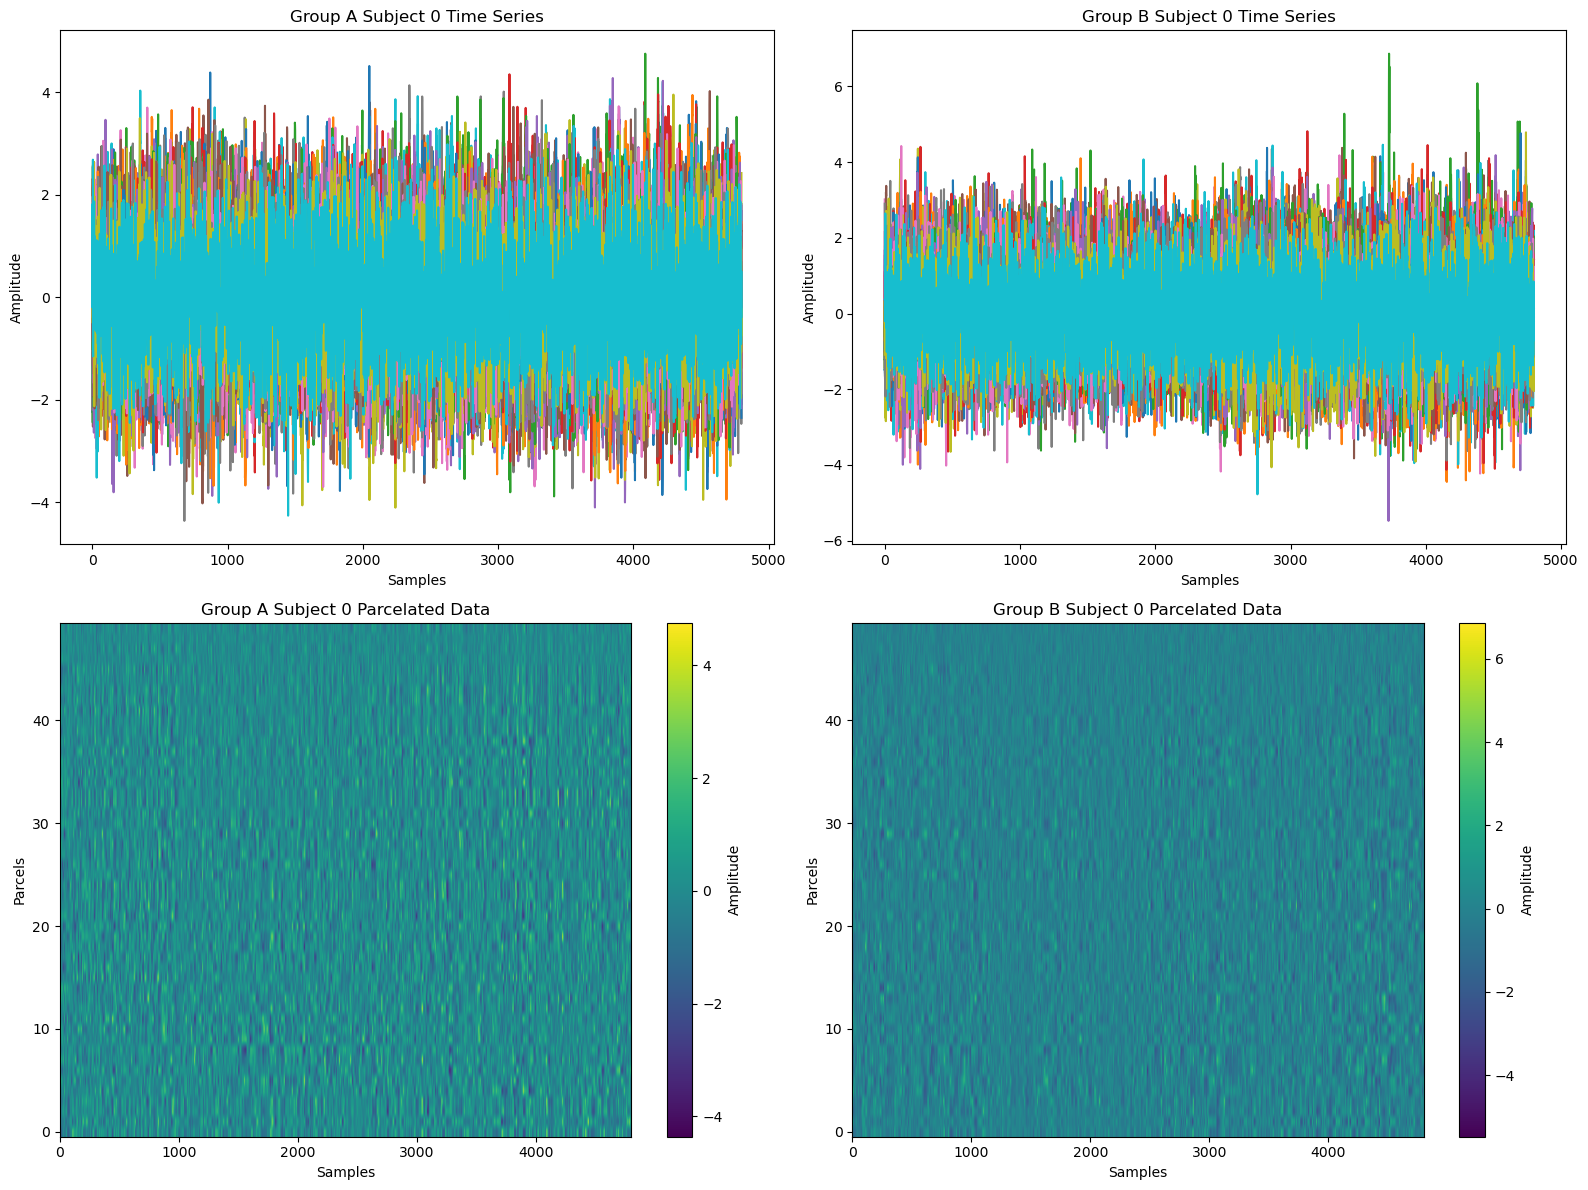

In [6]:
def standardize_demean_individual(group):
    n_subjects, n_timepoints, n_features = group.shape
    preprocessed_group = np.zeros_like(group)

    for i in range(n_subjects):
        subject = group[i]
        
        # Handle NaNs by imputing with the mean of the column
        imputer = SimpleImputer(strategy='mean')
        subject_imputed = imputer.fit_transform(subject)
        
        # Standardize (demean and scale to unit variance) each subject individually
        scaler = StandardScaler()
        standardized_subject = scaler.fit_transform(subject_imputed)
        
        preprocessed_group[i] = standardized_subject

    return preprocessed_group

# Assuming groupA_data and groupB_data are defined
preprocessed_GroupA = standardize_demean_individual(groupA_data)
preprocessed_GroupB = standardize_demean_individual(groupB_data)
# Assuming visualize_semi_simulated_subject is defined
visualize_semi_simulated_subject(preprocessed_GroupA, preprocessed_GroupB)

### Load to Find Clusters

In [ ]:
# from scipy.linalg import cholesky
# from sklearn.metrics.pairwise import euclidean_distances
# from scipy.linalg import svd
# from numba import njit



# def get_weights(X, gauss_coef=2.0, neighbors=None):
#     distances = euclidean_distances(X)
#     weights = np.exp(-gauss_coef * distances**2)
#     if neighbors:
#         # Only keep the weights for nearest neighbors
#         for i in range(X.shape[0]):
#             sorted_indices = np.argsort(distances[i])
#             weights[i, sorted_indices[neighbors:]] = 0
#     return weights

# def chol_D(shape0, shape1, rho, reg_scale):
#     D = np.eye(shape0) * reg_scale
#     chol_factor = cholesky(D + rho * np.eye(shape1))
#     return D, chol_factor

# def SVD(A, problem_rank):
#     U, s, Vh = svd(A, full_matrices=False)
#     U = U[:, :problem_rank]
#     s = s[:problem_rank]
#     Vh = Vh[:problem_rank, :]
#     return U, s, Vh

# def cprox(D_A, penalty, rho, weights):
#     norm_DA = np.sqrt(np.sum(D_A**2, axis=1))
#     threshold = penalty / rho
#     shrinkage = np.maximum(0, 1 - threshold / (norm_DA + 1e-10))
#     return shrinkage[:, np.newaxis] * D_A

# @njit
# def prox_numba_arr(G, D_A_Z1, penalty, rho, weights):
#     norm_DA = np.sqrt(np.sum(D_A_Z1**2, axis=1))
#     threshold = penalty / rho
#     shrinkage = np.maximum(0, 1 - threshold / (norm_DA + 1e-10))
#     return shrinkage[:, np.newaxis] * D_A_Z1

# def pcmf_ADMM(X, penalty_list, problem_rank=1, rho=1.0, admm_iters = 5, verb=False, weights=False, neighbors=None, gauss_coef=2.0, print_progress=True, parallel=False, output_file='NaN', numba=False):
#     '''
#     Pathwise Clustered Matrix Factorization (PCMF)
#     Fits fully constrained PCMF problem iterating between convex clustering and an SVD of rank 'problem_rank' using ADMM updates.
#     '''
#     # Initialize                                                                                                     
#     if weights is False:
#         weights = get_weights(X,gauss_coef=0.0)
#     else:
#         weights = get_weights(X,gauss_coef=gauss_coef, neighbors=neighbors)
#     D, chol_factor = chol_D(X.shape[0], X.shape[1], rho, reg_scale=1.0+rho)
#     G = Z1 = D*X
#     A = Z2 = X.copy()
#     U, s, Vh = SVD(A, problem_rank)

#     A_list = []
#     U_list = []
#     s_list = []
#     V_list = []
#     #
#     try:
#         # Iterate over penalty grid fitting problem for each value
#         for i in range(len(penalty_list)):
#             penalty = penalty_list[i]
#             num_obs = X.shape[0]
#             num_var = X.shape[1]
#             if print_progress == True:
#                 if parallel == True:
#                     file1 = open(output_file, "a")
#                     file1.write(str([i+1])+" {:.5e}".format(penalty))
#                     file1.write("...")
#                     file1.close()
#                 else:                                                        
#                     print("[",i+1,"]","{:.5e}".format(penalty), end="")
#                     print("...", end="")

#             for it in range(admm_iters):
#                 if numba is False:
#                     A = chol_factor(X + rho*D.T*(G - Z1) + rho*(np.dot(U*s,Vh) - Z2))
#                     G = cprox(D*A+Z1, penalty, rho, weights)
#                 else:
#                     A = chol_factor(X + rho*D.T*(G - Z1) + rho*(np.dot(U*s,Vh) - Z2))
#                     G = prox_numba_arr(np.zeros_like(G), D*A+Z1, penalty, rho, weights)
#                 #
#                 U, s, Vh = SVD(A + Z2, problem_rank)
#                 #
#                 Z1 = Z1 + rho*(D*A - G)
#                 Z2 = Z2 + rho*(A - np.dot(U*s,Vh))
#             #
#             A_list.append(A)
#             V_list.append(Vh)
#             s_list.append(s)
#             U_list.append(U)
#             #
#     except KeyboardInterrupt:
#         print("KeyboardInterrupt has been caught.")
#     return A_list, U_list, s_list, V_list

# from sklearn.metrics.pairwise import euclidean_distances
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import re
import pandas as pd
from k_means_constrained import KMeansConstrained


def visualize_semi_simulated_subject(groupA_data, groupB_data):
    """
    Visualize the semi-simulated subjects' data.

    Parameters:
    groupA_data (numpy.ndarray): Simulated data for group A.
    groupB_data (numpy.ndarray): Simulated data for group B.
    """
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

    axes[0, 0].plot(groupA_data[0, :, :])
    axes[0, 0].set_title('Group A Subject 0 Time Series')
    axes[0, 0].set_xlabel('Samples')
    axes[0, 0].set_ylabel('Amplitude')

    axes[0, 1].plot(groupB_data[0, :, :])
    axes[0, 1].set_title('Group B Subject 0 Time Series')
    axes[0, 1].set_xlabel('Samples')
    axes[0, 1].set_ylabel('Amplitude')

    img = axes[1, 0].imshow(groupA_data[0, :, :].T, aspect='auto', cmap='viridis', origin='lower')
    cbar = plt.colorbar(img, ax=axes[1, 0])
    cbar.set_label('Amplitude')
    axes[1, 0].set_title('Group A Subject 0 Parcelated Data')
    axes[1, 0].set_xlabel('Samples')
    axes[1, 0].set_ylabel('Parcels')
    
    img = axes[1, 1].imshow(groupB_data[0, :, :].T, aspect='auto', cmap='viridis', origin='lower')
    cbar = plt.colorbar(img, ax=axes[1, 1])
    cbar.set_label('Amplitude')
    axes[1, 1].set_title('Group B Subject 0 Parcelated Data')
    axes[1, 1].set_xlabel('Samples')
    axes[1, 1].set_ylabel('Parcels')

    plt.tight_layout()
    plt.show()

def standardize_demean_individual(group):
    n_subjects, n_timepoints, n_features = group.shape
    preprocessed_group = np.zeros_like(group)

    for i in range(n_subjects):
        subject = group[i]
        
        # Handle NaNs by imputing with the mean of the column
        imputer = SimpleImputer(strategy='mean')
        subject_imputed = imputer.fit_transform(subject)
        
        # Standardize (demean and scale to unit variance) each subject individually
        scaler = StandardScaler()
        standardized_subject = scaler.fit_transform(subject_imputed)
        
        preprocessed_group[i] = standardized_subject

    return preprocessed_group

def select_subs(group_type="WM",metric="riemann"):
    # subjects_path = r'/project/3022057.01/icp_parcellated_subs'
    subjects_path = r'/project/3022057.01/glasser_parcellated_subs'
    pathnames = []
    # Load the data file with the correct path
    # file_path = r'../HCP/RESTRICTED_zainsou_8_6_2024_2_11_21.csv'
    for subdir, dirs, files in os.walk(subjects_path):
        for file in files:
                if group_type in file:
                    pathnames.append(os.path.join(subdir,file))    
    
    X = []
    for path in pathnames:
        if np.load(path).shape[0] == np.load(pathnames[0]).shape[0]:
                X.append(np.load(path))

    X = np.array(X)
    X_preprocessed = standardize_demean_individual(X)
    cov_est = Covariances(estimator='lwf')
    X_covs = cov_est.transform(np.transpose(X_preprocessed, (0, 2, 1)))
    group_Mean = mean_covariance(X_covs, metric=metric)
    tangent_projected = tangent_space(X_covs, group_Mean, metric=metric)
    tansubs_PCA = PCA(n_components=10)
    # print(tangent_projected.T.shape)
    tansubs_PCA.fit(tangent_projected.T)
    # print(tansubs_PCA.explained_variance_ratio_)
    # print(tansubs_PCA.components_.shape)
    # print(tansubs_PCA.components_)
    components = tansubs_PCA.components_
    std_dev = np.std(components, axis=1)
    # print(std_dev.shape)

    # Get indices of significant contributions
    significant_indices = []
    for i, component in enumerate(components):
        significant_contributions = np.where(np.abs(component) > std_dev[i])[0]
        significant_indices.append(significant_contributions)

    significant_pc3 = set(significant_indices[1])
    significant_pc4 = set(significant_indices[2])
    significant_only_pc3 = list(significant_pc3 - significant_pc4)
    significant_only_pc4 = list(significant_pc4 - significant_pc3)

    return X_preprocessed[significant_only_pc3,:,:], X_preprocessed[significant_only_pc4,:,:]
    # print("Indices significant for PC3 but not PC4:", list(significant_only_pc3),len(list(significant_only_pc3)))
    # print("Indices significant for PC4 but not PC3:", list(significant_only_pc4),len(list(significant_only_pc4))) 
    # tan_u, tan_s, tan_v = np.linalg.svd(tangent_projected,full_matrices=False)
    # minor_tan = tan_u[:, 5:]@np.diag(tan_s[5:])@tan_v[5:,:]
    # print(minor_tan.shape)
    # # Perform K-Means clustering
    # k = 2  # Number of clusters
    # # kmeans = KMeans(n_clusters=k)
    # # kmeans.fit(minor_tan)
    # # labels = kmeans.labels_
    # # centroids = kmeans.cluster_centers_
    # # # Calculate pairwise distances between centroids
    # # centroid_distances = cdist(centroids, centroids, metric='euclidean')

    # clf = KMeansConstrained(n_clusters=k, size_min=100,random_state=0)
    # clf.fit_predict(minor_tan)
    # centroids = clf.cluster_centers_
    # labels = clf.labels_
    # centroid_distances = cdist(centroids, centroids, metric='euclidean')


    # # Find the indices of the clusters that are furthest apart
    # furthest_clusters = np.unravel_index(np.argmax(centroid_distances, axis=None), centroid_distances.shape)

    # print(f"The furthest clusters are: {furthest_clusters}")
    # print(f"Centroid distance: {centroid_distances[furthest_clusters]}")
    # # Get cluster centroids and labels
    # # Initialize UMAP and fit the data
    # umap_model = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean')
    # X_umap = umap_model.fit_transform(minor_tan)

    # # Plot the scatter plot with labels
    # plt.figure(figsize=(10, 8))
    # colors = ['blue', 'red', 'green', 'orange', 'purple']  # Adjust colors if k > 5

    # for i in range(k):
    #     plt.scatter(X_umap[labels == i, 0], X_umap[labels == i, 1], c=colors[i], label=f'Cluster {i}', alpha=0.5)
        
    #     # # Highlight the 100 closest points to each centroid
    #     # closest_points = np.argsort(pairwise_distances(tangent_projected[labels == i], [centroids[i]], metric='euclidean').flatten())[:100]
    #     # plt.scatter(X_umap[labels == i][closest_points, 0], X_umap[labels == i][closest_points, 1], c='black', marker='x')

    # plt.xlabel('UMAP component 1')
    # plt.ylabel('UMAP component 2')
    # plt.title('UMAP of Clusters with Closest Points')
    # plt.legend()
    # plt.show()

    # return X_preprocessed[labels == furthest_clusters[0]][np.argsort(pairwise_distances(tangent_projected[labels == furthest_clusters[0]], [centroids[furthest_clusters[0]]], metric='euclidean').flatten())[:100], :,:], X_preprocessed[labels == furthest_clusters[1]][np.argsort(pairwise_distances(tangent_projected[labels == furthest_clusters[1]], [centroids[furthest_clusters[1]]], metric='euclidean').flatten())[:100], :,:]
    # return X_preprocessed[labels == furthest_clusters[0]], X_preprocessed[labels == furthest_clusters[1]]
    # # Calculate pairwise Riemannian distances
    # n_matrices = tangent_projected.shape[0]
    # dist_matrix = np.zeros((n_matrices, n_matrices))
    # print(n_matrices)
    # for i in range(n_matrices):
    #     for j in range(i, n_matrices):
    #         dist = np.linalg.norm(tangent_projected[i, :] - tangent_projected[j, :])
    #         dist_matrix[i, j] = dist
    #         dist_matrix[j, i] = dist  # Symmetric matrix
    
    # # Perform hierarchical clustering on the distance matrix
    # linkage_matrix = linkage(tangent_projected, metric='euclidean')
    # # Reorder the matrix based on the clustering
    # dendro = dendrogram(linkage_matrix)
    # return dendro

preprocessed_GroupA, preprocessed_GroupB = select_subs(group_type="REST",metric="logeuclid")
visualize_semi_simulated_subject(preprocessed_GroupA, preprocessed_GroupB)

### Create Covariance Matrices (REVIST INCOMPLETE)

TODO Partial Covariances?
lwf towards group averages?

In [9]:
# https://pyriemann.readthedocs.io/en/latest/auto_examples/signal/plot_covariance_estimation.html
cov_est = Covariances(estimator='lwf')

# Compute the covariance matrices for preprocessed_GroupA and preprocessed_GroupB
groupA_covs = cov_est.transform(np.transpose(preprocessed_GroupA, (0, 2, 1)))
groupB_covs = cov_est.transform(np.transpose(preprocessed_GroupB, (0, 2, 1)))
print(groupA_covs.shape, groupB_covs.shape)

(101, 50, 50) (101, 50, 50)


### MIGP/Group Reductions

1. Should I demean at the group level after MIGP?
2. When to include MIGP
3. Have to weight groups contributions correctly

In [8]:
from scipy.linalg import svd
# TODO Reread MIGP to compare differences 
def incremental_pca_update(W, new_data, m):
    combined_data = np.vstack((W, new_data))
    U, S, Vt = svd(combined_data, full_matrices=False)
    return np.dot(((np.diag(S[:m])**2)/((combined_data.shape[0]))), Vt[:m, :])

def MIGP(group1, m, batch_size, group2=None):
    # Initialize W with the first batch of subjects from group A
    initial_data = group1[:batch_size].reshape(-1, group1.shape[2])
    U, S, Vt = svd(initial_data, full_matrices=False)
    W = np.dot(((np.diag(S[:m])**2)/((initial_data.shape[0]))), Vt[:m, :])
    
    # Process the remaining subjects in batches
    for i in range(batch_size, group1.shape[0], batch_size):
        batch_end = min(i + batch_size, group1.shape[0])
        new_data = group1[i:batch_end].reshape(-1, group1.shape[2])
        W = incremental_pca_update(W, new_data, m)
    
    if group2 is not None:
        # Process the remaining subjects in batches
        for i in range(batch_size, group2.shape[0], batch_size):
            batch_end = min(i + batch_size, group2.shape[0])
            new_data = group2[i:batch_end].reshape(-1, group2.shape[2])
            W = incremental_pca_update(W, new_data, m)
    
    W -= np.mean(W, axis=1, keepdims=True)

    return W

def svd_reduction(subjects_concat, n=0):
    if n==0:
        num_columns = subjects_concat.shape[1]
    else:
        num_columns = n
        
    U,_,_ = np.linalg.svd(subjects_concat,full_matrices=False)
    reduced_subjects = U[:,:num_columns].T@subjects_concat

    return reduced_subjects

if all_subs:
    subs_data = np.array(np.vstack((preprocessed_GroupA.reshape(-1, preprocessed_GroupA.shape[2]), preprocessed_GroupB.reshape(-1, preprocessed_GroupB.shape[2]))))
    subs_data_A = preprocessed_GroupA.reshape(-1, preprocessed_GroupA.shape[2])
    subs_data_B = preprocessed_GroupB.reshape(-1, preprocessed_GroupB.shape[2])
else:
    subs_data = MIGP(preprocessed_GroupA,150,1,preprocessed_GroupB)
    subs_data_A = MIGP(preprocessed_GroupA,150,1)
    subs_data_B = MIGP(preprocessed_GroupB,150,1)

### FKT/SPADE/CSP/GEVD/FDA (REVIST INCOMPLETE)

1. Using Full data for projections to calculate spade cost

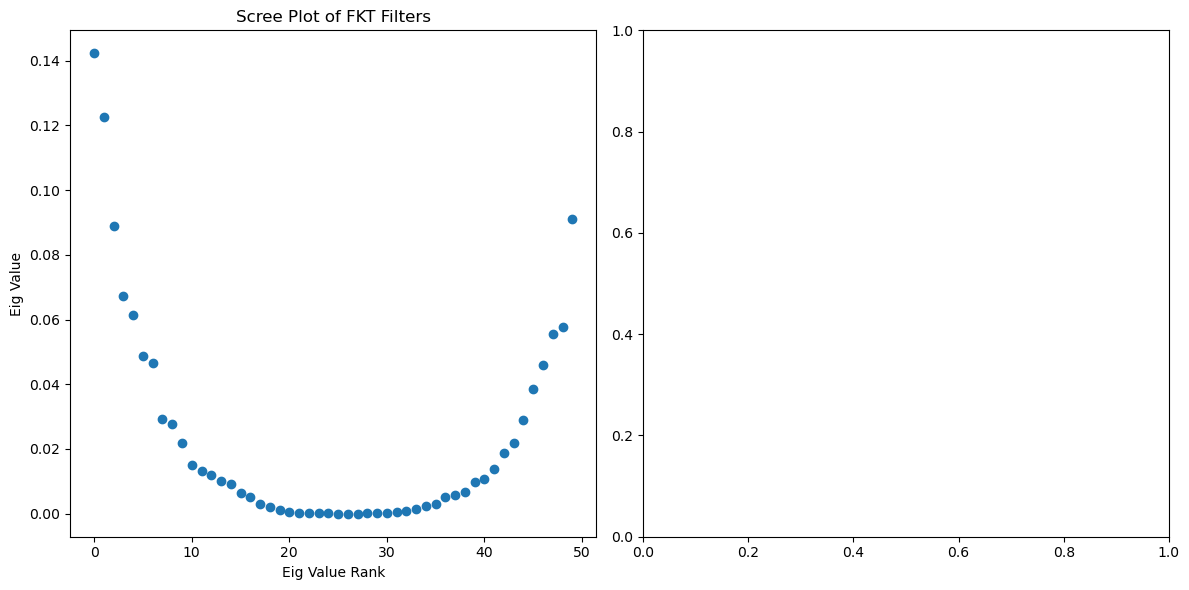

Sum of Axis Variance of Group A: 14.997880283901143
Sum of Axis Variance of Group B: 15.520066579916632


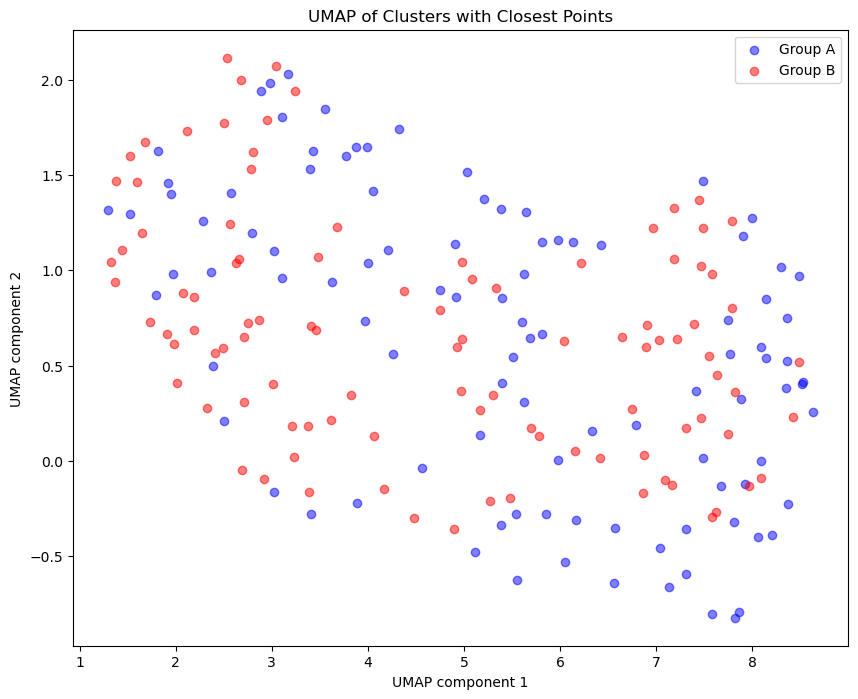

In [10]:
from sklearn.preprocessing import normalize

def SPADE_Cost(GroupA,GroupB,filters):
    # groupA = preprocessed_GroupA.reshape(-1, preprocessed_GroupA.shape[2])
    # groupB = preprocessed_GroupB.reshape(-1, preprocessed_GroupB.shape[2])
    return np.var(GroupA@np.linalg.pinv(filters.T), axis=0,ddof=1) - np.var(GroupB@np.linalg.pinv(filters.T), axis=0,ddof=1)
    # return np.var(GroupA@filters, axis=0) - np.var(GroupB@filters, axis=0)
    

def FKT(groupA_cov_matrices, groupB_cov_matrices, GroupA, GroupB, mean="riemann", average=True, visualize=True, gamma=0.0,n=0):
    if average:
        groupA_cov = mean_covariance(groupA_cov_matrices, metric=mean)
        groupB_cov = mean_covariance(groupB_cov_matrices, metric=mean)    
        # eigs, filters  = eigh(groupA_cov, groupA_cov + groupB_cov + gamma*np.identity(groupB_cov.shape[0]),eigvals_only=False)
        if n > 0:
            eigsA, filtersA  = eigh(groupA_cov, groupA_cov + groupB_cov,eigvals_only=False,subset_by_index=[groupA_cov.shape[0]-n, groupA_cov.shape[0]-1])
            eigsB, filtersB = eigh(groupB_cov, groupA_cov + groupB_cov,eigvals_only=False,subset_by_index=[groupB_cov.shape[0]-n, groupB_cov.shape[0]-1])
        else:
            eigsA, filtersA  = eigh(groupA_cov, groupA_cov + groupB_cov,eigvals_only=False,subset_by_value=[0.5,np.inf])
            eigsB, filtersB = eigh(groupB_cov, groupA_cov + groupB_cov,eigvals_only=False,subset_by_value=[0.5,np.inf])
       
        eigs = np.concatenate((eigsA[::-1], eigsB))
        filters = np.concatenate((filtersB[:, ::-1], filtersA), axis=1)

        fkt_riem_eigs = np.abs(np.log(eigs/(1-eigs)))**2

        # eigsB, filtersB = eigh(groupB_cov, groupA_cov + groupB_cov,eigvals_only=False)
        # plt.scatter(range(0,eigs.shape[0]),(eigs) - ((1-eigsB))[::-1],color="blue",label="Difference")
        # # plt.scatter(range(0,eigsB.shape[0]),((1-eigsB))[::-1],color="red",label="b")
        # plt.title('Check to make sure they are symmetric')
        # plt.legend()
        # plt.show()

        # group1 = eigh(groupA_cov,eigvals_only=True)
        # sns.heatmap(groupA_cov, cmap='viridis', xticklabels=False, yticklabels=False)
        # plt.title('Group A')
        # plt.show()
        # plt.scatter(range(0,group1.shape[0]),group1)
        # plt.title('Group A')
        # plt.show()
        # group2 = eigh(groupB_cov,eigvals_only=True)
        # sns.heatmap(groupB_cov, cmap='viridis', xticklabels=False, yticklabels=False)
        # plt.title('Group B')
        # plt.show()
        # plt.scatter(range(0,group2.shape[0]),group2)
        # plt.title('Group B')
        # plt.show()


        # # Calculate the nuclear norm (sum of absolute eigenvalues) for each group
        # nuclear_norm_groupA = np.sum(np.abs(group1))
        # nuclear_norm_groupB = np.sum(np.abs(group2))
        # # Output the nuclear norms
        # print("Nuclear Norm of Group A Average Covariance Matrix:", nuclear_norm_groupA)
        # print("Nuclear Norm of Group B Average Covariance Matrix:", nuclear_norm_groupB)

        # print("Intrinsic Dimensionality A:", (np.sum(group1)**2)/np.sum(group1**2))
        # print("Intrinsic Dimensionality B:", (np.sum(group2)**2)/np.sum(group2**2))

    else:
        eigs, filters = eigh(groupA_cov_matrices, groupB_cov_matrices,eigvals_only=False)
        # fkt_riem_eigs = np.abs(np.log((eigs-0.5)/(1-(eigs-0.5))))**2
        fkt_riem_eigs = np.abs(np.log(eigs))**2

        # eigsB, filtersB = eigh(groupB_cov_matrices, groupA_cov_matrices + groupB_cov_matrices)
    
    # Select eigenvalues and corresponding filters where eigsA > 0.5
    # selected_indices_A = eigsA > 0.5
    # selected_eigsA = eigsA[selected_indices_A]
    # selected_filtersA = filtersA[:, selected_indices_A]

    # # Select eigenvalues and corresponding filters where eigsB > 0.5
    # selected_indices_B = eigsB > 0.5
    # selected_eigsB = eigsB[selected_indices_B]
    # selected_filtersB = filtersB[:, selected_indices_B]

    # # Concatenate the selected eigenvalues and filters from both groups
    # eigs = np.concatenate((selected_eigsB[::-1], selected_eigsA))
    # filters = np.concatenate((selected_filtersB[:, ::-1], selected_filtersA), axis=1)


    # SPADE_eigs = np.abs(SPADE_Cost(GroupA,GroupB,filters))
    SPADE_eigs = None

    if visualize:
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        axs[0].scatter(range(0,fkt_riem_eigs.shape[0]),fkt_riem_eigs)
        axs[0].set_title('Scree Plot of FKT Filters')
        axs[0].set_xlabel('Eig Value Rank')
        axs[0].set_ylabel('Eig Value')

        # axs[1].scatter(range(0,filters.shape[1]),SPADE_eigs)
        # axs[1].set_title('Variance + Discrimination Score of Filters')
        # axs[1].set_xlabel('Filter Rank')
        # axs[1].set_ylabel('Variance + Discrimination Score of Filters')

        plt.tight_layout()
        plt.show()

        if average:
            all_covs = np.concatenate((groupA_cov_matrices, groupB_cov_matrices))
            Frechet_Mean = mean_covariance(all_covs, metric=metric)
            tangent_projected_1 = tangent_space(groupA_cov_matrices, Frechet_Mean, metric=metric)
            tangent_projected_2 = tangent_space(groupB_cov_matrices, Frechet_Mean, metric=metric)
            # Calculate variance along the appropriate axis
            variance_groupA = np.var(tangent_projected_1, axis=0)
            variance_groupB = np.var(tangent_projected_2, axis=0)

            # Print or return the variances
            print("Sum of Axis Variance of Group A:", np.sum(variance_groupA))
            print("Sum of Axis Variance of Group B:", np.sum(variance_groupB))
            tangent_projected = np.concatenate((tangent_projected_1, tangent_projected_2))
            umap_model = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean')
            X_umap = umap_model.fit_transform(tangent_projected)

            # Plot the scatter plot with labels
            plt.figure(figsize=(10, 8))
            plt.scatter(X_umap[:groupA_cov_matrices.shape[0], 0], X_umap[:groupA_cov_matrices.shape[0], 1], c='blue', label='Group A', alpha=0.5)
            plt.scatter(X_umap[groupA_cov_matrices.shape[0]:, 0], X_umap[groupA_cov_matrices.shape[0]:, 1], c='red', label='Group B', alpha=0.5)
            plt.xlabel('UMAP component 1')
            plt.ylabel('UMAP component 2')
            plt.title('UMAP of Clusters with Closest Points')
            plt.legend()
            plt.show()
        
    return SPADE_eigs, filters, fkt_riem_eigs

def tangent_CSP(GroupA, GroupB, group1_covs=None, group2_covs=None, Frechet_Mean=None,tangent_projected_1=None, tangent_projected_2=None, tangent_calc=True, metric="riemann",k=1, visualize=False):
    if tangent_calc:
        all_covs = np.concatenate((group1_covs, group2_covs))
        Frechet_Mean = mean_covariance(all_covs, metric=metric)
        tangent_projected_1 = tangent_space(group1_covs, Frechet_Mean, metric=metric)
        tangent_projected_2 = tangent_space(group2_covs, Frechet_Mean, metric=metric)
        

    # Initialize the Covariances estimator
    cov_estimator = Covariances(estimator='lwf')
    tangent_projected_mean = np.mean(np.concatenate((tangent_projected_1, tangent_projected_2)),axis=0,keepdims=True)  
    
    tangent_1_mean = np.mean(tangent_projected_1,axis=0,keepdims=True) - tangent_projected_mean
    tangent_2_mean = np.mean(tangent_projected_2,axis=0,keepdims=True) - tangent_projected_mean
    tangent_between_scatter = tangent_1_mean.T@tangent_1_mean + tangent_2_mean.T@tangent_2_mean
    

    tangent_projected = np.concatenate((tangent_projected_1,tangent_projected_2))
    # Use UMAP instead of t-SNE
    umap_model = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean')
    X_umap = umap_model.fit_transform(tangent_projected)

    # Plot the scatter plot with labels
    plt.figure(figsize=(10, 8))
    plt.scatter(X_umap[:group1_covs.shape[0], 0], X_umap[:group1_covs.shape[0], 1], c='blue', label='Group A', alpha=0.5)
    plt.scatter(X_umap[group1_covs.shape[0]:, 0], X_umap[group1_covs.shape[0]:, 1], c='red', label='Group B', alpha=0.5)
    plt.xlabel('UMAP component 1')
    plt.ylabel('UMAP component 2')
    plt.title('UMAP of Clusters with Closest Points')
    plt.legend()
    plt.show()


    # Estimate the covariance matrices
    cov_tangent_projected_1 = cov_estimator.transform(np.transpose(tangent_projected_1[np.newaxis,:,:],(0,2,1)))[0]
    cov_tangent_projected_2 = cov_estimator.transform(np.transpose(tangent_projected_2[np.newaxis,:,:],(0,2,1)))[0]
    

    # Convert to PyTorch tensors and move to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(("cuda" if torch.cuda.is_available() else "cpu"))
    cov_tangent_projected_1 = torch.tensor(cov_tangent_projected_1, dtype=torch.float32, device=device)
    cov_tangent_projected_2 = torch.tensor(cov_tangent_projected_2, dtype=torch.float32, device=device) 
    tangent_between_scatter = torch.tensor(tangent_between_scatter, dtype=torch.float32, device=device)
    
    # For filtersA
    _, eigvecs = torch.lobpcg(tangent_between_scatter, B=cov_tangent_projected_1 + cov_tangent_projected_2 + 0.0 * torch.eye(cov_tangent_projected_1.shape[0], device=cov_tangent_projected_1.device), k=k, largest=True)
    eigvecs_array = eigvecs.clone().cpu().numpy()
    filters = untangent_space(eigvecs_array.T, Frechet_Mean)
    SPADE_eigs_tangent, fkt_filters_tangent, fkt_riem_eigs_tangent = FKT(filters[0,:,:], Frechet_Mean, GroupA, GroupB, mean=metric, average=False, visualize=visualize, gamma=0.0)

    return SPADE_eigs_tangent, fkt_filters_tangent, fkt_riem_eigs_tangent

def tangent_classifier(GroupA, GroupB, group1_covs=None, group2_covs=None, Frechet_Mean=None, tangent_projected_1=None, tangent_projected_2=None, TSVM=False, TLDA=True, tangent_calc=True,metric="riemann",visualize=False,n=0):
    if tangent_calc:
        all_covs = np.concatenate((group1_covs, group2_covs))
        Frechet_Mean = mean_covariance(all_covs, metric=metric)
        tangent_projected_1 = tangent_space(group1_covs, Frechet_Mean, metric=metric)
        tangent_projected_2 = tangent_space(group2_covs, Frechet_Mean, metric=metric)
    # Create labels for each group
    labels_1 = np.ones(len(tangent_projected_1))  # Labels for group 1
    labels_2 = np.zeros(len(tangent_projected_2))   # Labels for group 2
    
    # if visualize:
    #     tangent_projected = np.concatenate((tangent_projected_1,tangent_projected_2))
    #     # Use UMAP instead of t-SNE
    #     umap_model = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.1, metric='euclidean')
    #     X_umap = umap_model.fit_transform(tangent_projected)

    #     # Plot the scatter plot with labels
    #     plt.figure(figsize=(10, 8))
    #     plt.scatter(X_umap[:labels_1.shape[0], 0], X_umap[:labels_1.shape[0], 1], c='blue', label='Group A', alpha=0.5)
    #     plt.scatter(X_umap[labels_1.shape[0]:, 0], X_umap[labels_1.shape[0]:, 1], c='red', label='Group B', alpha=0.5)
    #     plt.xlabel('UMAP component 1')
    #     plt.ylabel('UMAP component 2')
    #     plt.title('UMAP of Clusters with Closest Points')
    #     plt.legend()
    #     plt.show()

    # Combine data and labels
    # Samples (e.g 198) x Features (e.g. 21736)
    data = np.concatenate((tangent_projected_1, tangent_projected_2))
    # Samples (e.g. 198)
    labels = np.concatenate((labels_1, labels_2))
    # print(data.shape,labels.shape)
    if TSVM:
        # Create SVM classifier (adjust kernel and parameters as needed)
        # clf = LinearSVC(penalty='l1',loss='squared_hinge',dual=False, C=1)  
        # clf = SVC(kernel='linear', C=1)  
        clf = SVC(kernel='linear')  
        # Train the classifier
        clf.fit(data, labels)
        normalized_coef = normalize(clf.coef_, axis=1)
        filters_SVM = untangent_space(normalized_coef, Frechet_Mean)
        SPADE_eigs_tangent_SVM, fkt_filters_tangent_SVM, fkt_riem_eigs_tangent_SVM = FKT(filters_SVM[0,:,:], Frechet_Mean, GroupA, GroupB, mean=metric, average=False, visualize=visualize, gamma=0.0,n=n)
        return SPADE_eigs_tangent_SVM, fkt_filters_tangent_SVM, fkt_riem_eigs_tangent_SVM

    if TLDA:
        # Create LDA classifier
        lda = LDA()
        # Train the classifier
        lda.fit(data, labels)
        # Get the coefficients from LDA
        normalized_coef = normalize(lda.coef_, axis=1)
        filters_LDA = untangent_space(normalized_coef, Frechet_Mean)
        SPADE_eigs_tangent_LDA, fkt_filters_tangent_LDA, fkt_riem_eigs_tangent_LDA = FKT(filters_LDA[0,:,:], Frechet_Mean, GroupA, GroupB, mean=metric, average=False, visualize=visualize, gamma=0.0,n=n)
        return SPADE_eigs_tangent_LDA, fkt_filters_tangent_LDA, fkt_riem_eigs_tangent_LDA

if Tangent_Class:
    SPADE_eigs, fkt_filters, fkt_riem_eigs = tangent_classifier(subs_data_A,subs_data_B, group1_covs=groupA_covs, group2_covs=groupB_covs, TSVM=True, TLDA=False,tangent_calc=True,metric=metric, visualize=True)
elif Tangent_CSP:
    SPADE_eigs, fkt_filters, fkt_riem_eigs = tangent_CSP(subs_data_A, subs_data_B, group1_covs=groupA_covs, group2_covs=groupB_covs, tangent_calc=True, metric=metric,  k=1, visualize=True)
else:
    SPADE_eigs, fkt_filters, fkt_riem_eigs = FKT(groupA_covs, groupB_covs,subs_data_A,subs_data_B, mean=metric, average=True, visualize=True, gamma=0.0)

In [ ]:
# filters = fkt_filters[:,[0,-2,-1]]
# print(np.var(subs_data_A@filters,axis=0) - np.var(subs_data_B@filters,axis=0))
# filters_A = fkt_filters[:,[-2,-1]]
# filters_B = fkt_filters[:,[0]]

### Create Null Distribution via Permutation Testing (REVIST INCOMPLETE)

1. Using Full data for projections to calculate spade cost

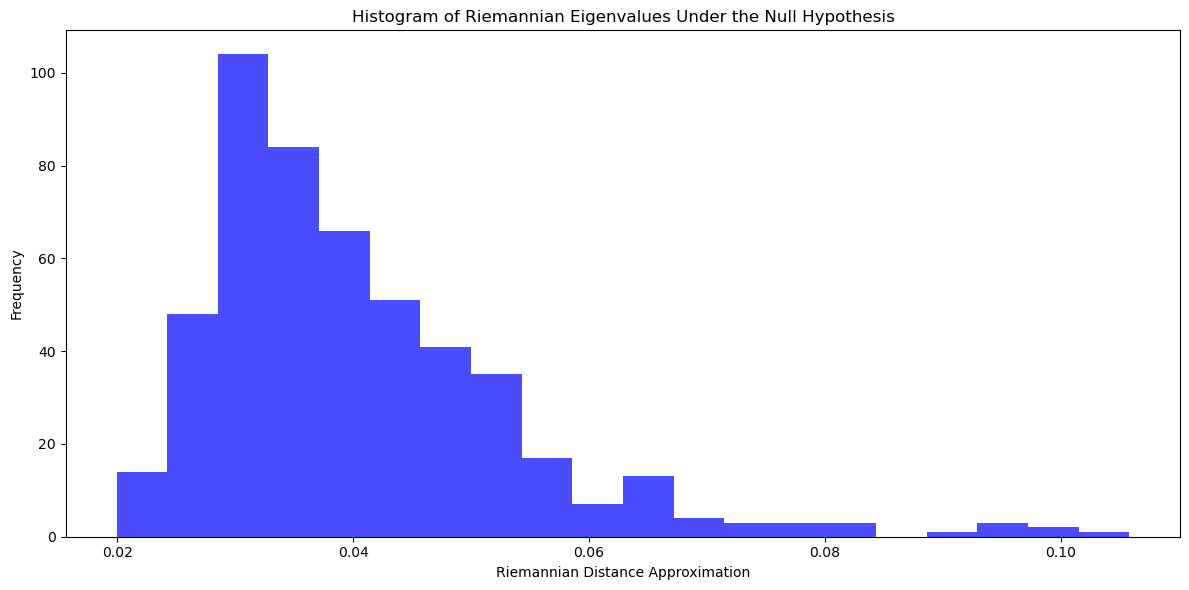

In [13]:
from concurrent.futures import ProcessPoolExecutor

def single_run_fkt(data, n_classA, filters_func,metric="riemann"):
    # Shuffle the combined data locally
    indices = np.arange(data.shape[0])
    shuffled_indices = np.random.permutation(indices)
    shuffled_covs = data[shuffled_indices,:,:]
    shuffled_groupA_covs = shuffled_covs[:n_classA,:,:]
    shuffled_groupB_covs = shuffled_covs[n_classA:,:,:]
    # Calculate filters using the permuted data
    _, _, riem_distances = filters_func(shuffled_groupA_covs, shuffled_groupB_covs, None, None, mean=metric, average=True, visualize=False, gamma=0.0,n=1)

    return np.array([np.max(riem_distances)])

def single_run_Tangent_Class(data, n_classA, filters_func, Frechet, metric="riemann"):
    # Shuffle the combined data locally
    indices = np.arange(data.shape[0])
    shuffled_indices = np.random.permutation(indices)
    shuffled_tangent = data[shuffled_indices,:]
    shuffled_groupA_tangent = shuffled_tangent[:n_classA,:]
    shuffled_groupB_tangent = shuffled_tangent[n_classA:,:]
    # Calculate filters using the permuted data
    _, _, riem_distances = filters_func(None, None, group1_covs=None, group2_covs=None, Frechet_Mean=Frechet, tangent_projected_1=shuffled_groupA_tangent, tangent_projected_2=shuffled_groupB_tangent, TSVM=True, TLDA=False, tangent_calc=False, metric=metric,visualize=False,n=1)

    return np.array([np.max(riem_distances)])

def simulate_FKT(groupA_covs, groupB_covs, filters_func, n_simulations=10,metric="riemann"):
    riem_distances = []
    with ProcessPoolExecutor(max_workers=int(os.environ['PBS_NP'])) as executor:
        n_classA = groupA_covs.shape[0]
        combined_data = np.vstack([groupA_covs, groupB_covs])
        if filters_func is FKT:
            futures = [executor.submit(single_run_fkt, combined_data, n_classA, filters_func,metric=metric) for _ in range(n_simulations)]
        elif filters_func is tangent_classifier:
            Frechet_Mean = mean_covariance(combined_data, metric=metric)
            tangent_projected = tangent_space(combined_data, Frechet_Mean, metric=metric)
            futures = [executor.submit(single_run_Tangent_Class, tangent_projected, n_classA, filters_func,Frechet_Mean,metric=metric) for _ in range(n_simulations)]

        for future in futures:
            perm_result = future.result()
            riem_distances.extend(perm_result)
        
    # Visualize the results for permuted distances
    plt.figure(figsize=(12, 6))
    plt.hist(riem_distances, bins=20, color='blue', alpha=0.7)
    plt.title('Histogram of Riemannian Eigenvalues Under the Null Hypothesis')
    plt.xlabel('Riemannian Distance Approximation')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    return riem_distances, None

if Tangent_Class:
    riem_distances, var_discrim_distances = simulate_FKT(groupA_covs, groupB_covs, tangent_classifier,n_simulations=20,metric=metric)
else:
    riem_distances, var_discrim_distances = simulate_FKT(groupA_covs, groupB_covs, FKT,n_simulations=500,metric=metric)

In [ ]:
# from concurrent.futures import ProcessPoolExecutor

# def single_run_fkt(data, n_classA, GroupA, GroupB, filters_func,metric="riemann"):
#     # Shuffle the combined data locally
#     np.random.shuffle(data)
#     new_classA = data[:n_classA]
#     new_classB = data[n_classA:]
#     del data
#     # Calculate filters using the permuted data
#     var_discrim_distances, _, riem_distances = filters_func(new_classA, new_classB, GroupA, GroupB, mean=metric, average=True, visualize=True)
    
#     return riem_distances, var_discrim_distances

# def single_run_tangent(data, n_classA,Frechet_Mean, GroupA, GroupB, filters_func,metric):
#     # Shuffle the combined data locally
#     np.random.shuffle(data)
#     new_classA = data[:n_classA,:]
#     new_classB = data[n_classA:,:]
    
#     # Calculate filters using the permuted data
#     var_discrim_distances, _, riem_distances = filters_func(GroupA, GroupB,  group1_covs=None, group2_covs=None, Frechet_Mean=Frechet_Mean, tangent_projected_1=new_classA, tangent_projected_2=new_classB, TSVM=True, TLDA=False, tangent_calc=False,metric=metric,visualize=True)
    
#     return riem_distances, var_discrim_distances

# def single_run_tangent_CSP(data, n_classA,Frechet_Mean, GroupA, GroupB, filters_func,metric):
#     # Shuffle the combined data locally
#     np.random.shuffle(data)
#     new_classA = data[:n_classA,:]
#     new_classB = data[n_classA:,:]
    
#     # Calculate filters using the permuted data
#     var_discrim_distances, _, riem_distances = filters_func(GroupA, GroupB,  group1_covs=None, group2_covs=None, Frechet_Mean=Frechet_Mean, tangent_projected_1=new_classA, tangent_projected_2=new_classB, tangent_calc=False,metric=metric, k=1, visualize=False)
    
#     return riem_distances, var_discrim_distances

# def simulate_FKT(GroupA, GroupB, groupA_covs, groupB_covs, filters_func, n_simulations=10,metric="riemann"):
#     riem_distances = []
#     var_discrim_distances = []
#     if filters_func is tangent_CSP:
#             # all_covs = np.concatenate((groupA_covs, groupB_covs))
#             # Frechet_Mean = mean_covariance(all_covs, metric=metric)
#             # tangent_projected_1 = tangent_space(groupA_covs, Frechet_Mean, metric=metric)
#             # tangent_projected_2 = tangent_space(groupB_covs, Frechet_Mean, metric=metric)
#             # n_classA = tangent_projected_1.shape[0]
#             # combined_data = np.vstack([tangent_projected_1, tangent_projected_2])
#             # # futures = [executor.submit(single_run_tangent_CSP, combined_data.copy(), n_classA, Frechet_Mean, GroupA, GroupB, filters_func, metric) for _ in range(n_simulations)]
#             # for _ in range(n_simulations):
#             #     perm_result, alt_result = single_run_tangent_CSP(
#             #         combined_data.copy(), n_classA, Frechet_Mean, GroupA, GroupB, filters_func, metric
#             #     )
#             #     if perm_result is not None:
#             #         riem_distances.extend(perm_result)
#             #     if alt_result is not None:
#             #         var_discrim_distances.extend(alt_result)
#             i = 0
#             for _ in range(n_simulations):
#                 n_classA = groupA_covs.shape[0]
#                 # combined_data = np.vstack([GroupA, GroupB])
#                 combined_covs = np.vstack([groupA_covs, groupB_covs])
#                 # Generate an array of indices
#                 indices = np.arange(combined_covs.shape[0])
#                 shuffled_indices = np.random.permutation(indices)
#                 # shuffled_data = combined_data[shuffled_indices,:,:]
#                 shuffled_covs = combined_covs[shuffled_indices,:,:]
#                 # Extract the shuffled data corresponding to the original groups
#                 shuffled_groupA_covs = shuffled_covs[:n_classA,:,:]
#                 # print(shuffled_indices.shape)
#                 # print(shuffled_indices)
#                 # shuffled_groupA = shuffled_data[:n_classA,:,:].reshape(-1, shuffled_data.shape[2])
#                 shuffled_groupB_covs = shuffled_covs[n_classA:,:,:]
#                 # shuffled_groupB = shuffled_data[n_classA:,:,:].reshape(-1, shuffled_data.shape[2])

#                 # alt_result,_, perm_result = tangent_CSP(shuffled_groupA, shuffled_groupB, group1_covs=shuffled_groupA_covs, group2_covs=shuffled_groupB_covs, tangent_calc=True, metric=metric,  k=1, visualize=True)
#                 # alt_result,_, perm_result = FKT(shuffled_groupA_covs, shuffled_groupB_covs,shuffled_groupA,shuffled_groupB, mean=metric, average=True, visualize=True, gamma=0.0)
#                 # alt_result,_, perm_result = tangent_CSP(GroupA.reshape(-1, shuffled_groupA_covs.shape[2]), GroupB.reshape(-1, shuffled_groupA_covs.shape[2]), group1_covs=shuffled_groupA_covs, group2_covs=shuffled_groupB_covs, tangent_calc=True, metric=metric,  k=1, visualize=True)
#                 # alt_result,_, perm_result= tangent_classifier(GroupA.reshape(-1, shuffled_groupA_covs.shape[2]),GroupB.reshape(-1, shuffled_groupA_covs.shape[2]), group1_covs=shuffled_groupA_covs, group2_covs=shuffled_groupB_covs, TSVM=True, TLDA=False,tangent_calc=True,metric=metric, visualize=False)
#                 alt_result,_, perm_result = FKT(shuffled_groupA_covs, shuffled_groupB_covs,GroupA.reshape(-1, shuffled_groupA_covs.shape[2]),GroupB.reshape(-1, shuffled_groupA_covs.shape[2]), mean=metric, average=True, visualize=False, gamma=0.0,n=1)
#                 riem_distances.extend(np.array([np.max(perm_result)]))
#                 var_discrim_distances.extend(np.array([np.max(alt_result)]))
        
#     else:
#         with ProcessPoolExecutor(max_workers=int(os.environ['PBS_NP'])) as executor:
#             if filters_func is FKT:
#                 n_classA = groupA_covs.shape[0]
#                 combined_data = np.vstack([groupA_covs, groupB_covs])
#                 futures = [executor.submit(single_run_fkt, combined_data.copy(), n_classA, GroupA, GroupB, filters_func,metric=metric) for _ in range(n_simulations)]
#             elif filters_func is tangent_classifier:
#                 all_covs = np.concatenate((groupA_covs, groupB_covs))
#                 Frechet_Mean = mean_covariance(all_covs, metric=metric)
#                 tangent_projected_1 = tangent_space(groupA_covs, Frechet_Mean, metric=metric)
#                 tangent_projected_2 = tangent_space(groupB_covs, Frechet_Mean, metric=metric)
#                 n_classA = tangent_projected_1.shape[0]
#                 combined_data = np.vstack([tangent_projected_1, tangent_projected_2])
#                 futures = [executor.submit(single_run_tangent, combined_data.copy(), n_classA, Frechet_Mean, GroupA, GroupB, filters_func, metric) for _ in range(n_simulations)]

#             for future in futures:
#                 perm_result, alt_result = future.result()
#                 riem_distances.extend(perm_result)
#                 var_discrim_distances.extend(alt_result)
        
#     # Visualize the results for permuted distances
#     plt.figure(figsize=(12, 6))
#     plt.subplot(1, 2, 1)
#     plt.hist(riem_distances, bins=20, color='blue', alpha=0.7)
#     plt.title('Histogram of Riemannian Eigenvalues Under the Null Hypothesis')
#     plt.xlabel('Riemannian Distance Approximation')
#     plt.ylabel('Frequency')

#     # Visualize the results for alternate distances
#     plt.subplot(1, 2, 2)
#     plt.hist(var_discrim_distances, bins=20, color='red', alpha=0.7)
#     plt.title('Histogram of Variance Differences')
#     plt.xlabel('Variance Difference')
#     plt.ylabel('Frequency')

#     plt.tight_layout()
#     plt.show()

#     return riem_distances, var_discrim_distances

# if False:
#     riem_distances, var_discrim_distances = simulate_FKT(subs_data_A, subs_data_B, groupA_covs, groupB_covs, tangent_classifier,n_simulations=1, metric=metric)
# elif True:
#     riem_distances, var_discrim_distances = simulate_FKT(preprocessed_GroupA, preprocessed_GroupB, groupA_covs, groupB_covs, tangent_CSP,n_simulations=1000,metric=metric)
# else:
#     riem_distances, var_discrim_distances = simulate_FKT(subs_data_A, subs_data_B, groupA_covs, groupB_covs, FKT,n_simulations=1,metric=metric)

### Select FKT Components (REVIST INCOMPLETE)

1. Should QR Decomposition be used? (Should I orthonormalize the filters)
2. Is this the right way to calculate the eigenvalues?
3. Is model order selection valid?
4. Using Full data for projections to calculate spade cost

[0. 0.]


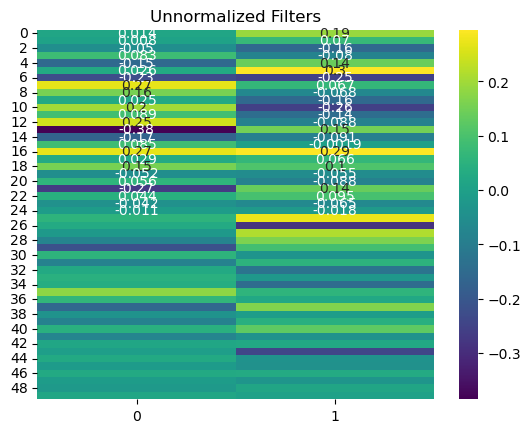

Orthonormalize Discriminant Filters


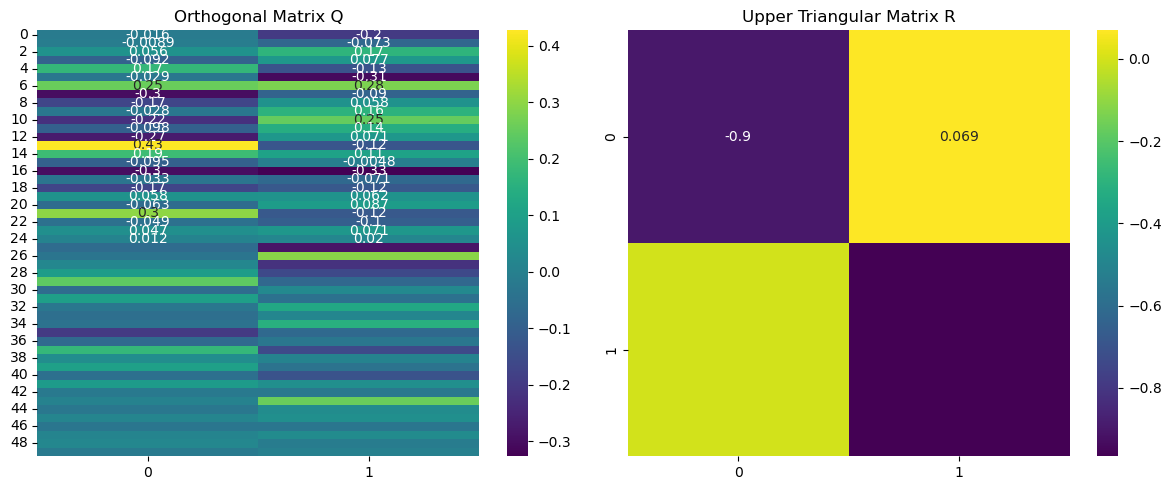

Total Number of Filters Chosen Via Riemannian Approximation Followed by Variance Explanation: 2


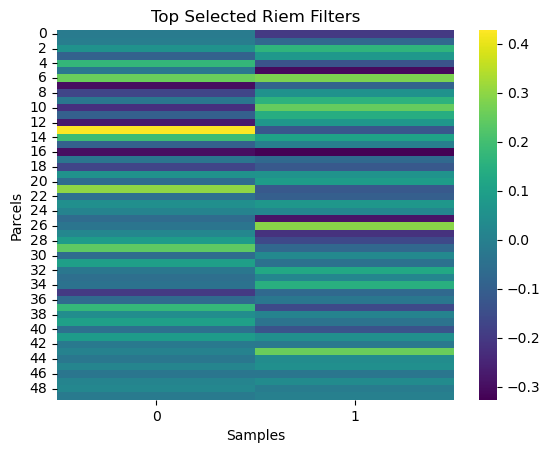

In [15]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import norm

def test_significance(null_distribution, test_statistics, alpha=0.05):
    """
    Calculate p-values for test statistics against a null distribution and apply Bonferroni correction.

    Parameters:
    - null_distribution (array-like): The distribution of values under the null hypothesis.
    - test_statistics (array-like): The statistics to test against the null distribution.
    - alpha (float): The significance level for the tests (default is 0.05).

    Returns:
    - p_values (np.array): The p-values for each test statistic.
    - significant_tests (np.array): Boolean array indicating which tests are significant.
    """
    
    # Calculate p-values
    p_values = np.array([np.mean(null_distribution >= ts) for ts in test_statistics])

    # https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html
    # Apply FDR correction using the Benjamini-Hochberg method fdr_bh or bonferroni
    reject, _, _, _ = multipletests(p_values, alpha=alpha, method='fdr_bh')

    return p_values, reject


def QR(basis, visualize=True):
    # Combine normalized projected filters with PCA components
        # QR decomposition
    Q, R = np.linalg.qr(basis)
    
    if visualize:
        # Plot Q matrix
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        sns.heatmap(Q, annot=True, cmap='viridis')
        plt.title("Orthogonal Matrix Q")

        # Plot R matrix
        plt.subplot(1, 2, 2)
        sns.heatmap(R, annot=True, cmap='viridis')
        plt.title("Upper Triangular Matrix R")

        plt.tight_layout()
        plt.show()
    else:
        plt.figure()
        sns.heatmap(R, annot=True, cmap='viridis')
        plt.title("Upper Triangular Matrix R")
        plt.show()

    return Q, R


def FKT_var_select(groupA, groupB, unorth_filters):
    plt.figure()
    sns.heatmap(unorth_filters, annot=True, cmap='viridis')
    plt.title("Unnormalized Filters")
    plt.show()
    print("Orthonormalize Discriminant Filters")
    filters, _ = QR(unorth_filters)
    # filters = unorth_filters
    var_explained = SPADE_Cost(groupA,groupB,filters)
    a_filters = np.where(var_explained > 0)[0]
    b_filters = np.where(var_explained < 0)[0]
    # Note SPADE_Cost is defined such that groupA is the positive class
    # print(var_explained)
    # print(SPADE_Cost(groupA,groupB,unorth_filters))
    # # Combine a_filters and b_filters into a single list
    combined_filters = np.concatenate((a_filters, b_filters))
    # Returning the combined filters and separated filters for group A and B
    return filters[:, combined_filters], filters[:, a_filters], filters[:, b_filters]    
    print("Select Group A Variance Explaining Discriminant Filters")
    A_eigs = np.var(groupA@np.linalg.pinv(filters[:,a_filters].T),axis=0,ddof=1)
    A_eigs_index = np.argsort(A_eigs)[::-1]
    N_A = groupA.shape[0]
    if A_eigs_index.shape[0] > 2:
        num_A_filters = call_pca_dim(eigs=A_eigs[A_eigs_index],N=N_A)
    else:
        num_A_filters = A_eigs_index.shape[0]
    reduced_filters_A = filters[:,a_filters][:,A_eigs_index[:num_A_filters]]


    print("Select Group B Variance Explaining Discriminant Filters")
    B_eigs = np.var(groupB@np.linalg.pinv(filters[:, b_filters].T),axis=0,ddof=1)
    B_eigs_index = np.argsort(B_eigs)[::-1]
    N_B = groupB.shape[0]
    if B_eigs_index.shape[0] > 2:
        num_B_filters = call_pca_dim(eigs=B_eigs[B_eigs_index],N=N_B)
    else:
        num_B_filters = B_eigs_index.shape[0]
    reduced_filters_B = filters[:,b_filters][:,B_eigs_index[:num_B_filters]]

    reduced_filters = np.concatenate((reduced_filters_A,reduced_filters_B),axis=1)

    print("Number of Group A Filters:", num_A_filters)
    print("Number of Group B Filters:", num_B_filters)

    return reduced_filters, reduced_filters_A, reduced_filters_B

p_values_riem, significant_tests_riem = test_significance(riem_distances, fkt_riem_eigs)
print(p_values_riem[significant_tests_riem])
if len(significant_tests_riem) > 0:
    top_filters_riem, top_filters_riem_A, top_filters_riem_B  = FKT_var_select(subs_data_A, subs_data_B,fkt_filters[:,significant_tests_riem])
    plt.figure()
    sns.heatmap(top_filters_riem, cmap='viridis')
    plt.title('Top Selected Riem Filters')
    plt.xlabel('Samples')
    plt.ylabel('Parcels')


print(f"Total Number of Filters Chosen Via Riemannian Approximation Followed by Variance Explanation: {top_filters_riem.shape[1]}")

if riem_filters:
    filters = top_filters_riem
    filters_A = top_filters_riem_A
    filters_B = top_filters_riem_B

In [ ]:
# from statsmodels.stats.multitest import multipletests
# from scipy.stats import norm

# def test_significance(null_distribution, test_statistics, alpha=0.05):
#     """
#     Calculate p-values for test statistics against a null distribution and apply Bonferroni correction.

#     Parameters:
#     - null_distribution (array-like): The distribution of values under the null hypothesis.
#     - test_statistics (array-like): The statistics to test against the null distribution.
#     - alpha (float): The significance level for the tests (default is 0.05).

#     Returns:
#     - p_values (np.array): The p-values for each test statistic.
#     - significant_tests (np.array): Boolean array indicating which tests are significant.
#     """
    
#     # Calculate p-values
#     p_values = np.array([np.mean(null_distribution >= ts) for ts in test_statistics])

#     # https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html
#     # Apply FDR correction using the Benjamini-Hochberg method fdr_bh or bonferroni
#     reject, _, _, _ = multipletests(p_values, alpha=alpha, method='bonferroni')

#     return p_values, reject


# def QR(basis, visualize=True):
#     # Combine normalized projected filters with PCA components
#         # QR decomposition
#     Q, R = np.linalg.qr(basis)
    
#     if visualize:
#         # Plot Q matrix
#         plt.figure(figsize=(12, 5))

#         plt.subplot(1, 2, 1)
#         sns.heatmap(Q, annot=True, cmap='viridis')
#         plt.title("Orthogonal Matrix Q")

#         # Plot R matrix
#         plt.subplot(1, 2, 2)
#         sns.heatmap(R, annot=True, cmap='viridis')
#         plt.title("Upper Triangular Matrix R")

#         plt.tight_layout()
#         plt.show()
#     else:
#         plt.figure()
#         sns.heatmap(R, annot=True, cmap='viridis')
#         plt.title("Upper Triangular Matrix R")
#         plt.show()

#     return Q, R


# def FKT_var_select(groupA, groupB, unorth_filters):
#     plt.figure()
#     sns.heatmap(unorth_filters, annot=True, cmap='viridis')
#     plt.title("Unnormalized Filters")
#     plt.show()
#     print("Orthonormalize Discriminant Filters")
#     filters, _ = QR(unorth_filters)
#     # filters = unorth_filters
#     var_explained = SPADE_Cost(groupA,groupB,filters)
#     a_filters = np.where(var_explained > 0)[0]
#     b_filters = np.where(var_explained < 0)[0]
#     # Note SPADE_Cost is defined such that groupA is the positive class
#     # print(var_explained)
#     # print(SPADE_Cost(groupA,groupB,unorth_filters))
#     # # Combine a_filters and b_filters into a single list
#     combined_filters = np.concatenate((a_filters, b_filters))
#     # Returning the combined filters and separated filters for group A and B
#     return filters[:, combined_filters], filters[:, a_filters], filters[:, b_filters]    
#     print("Select Group A Variance Explaining Discriminant Filters")
#     A_eigs = np.var(groupA@np.linalg.pinv(filters[:,a_filters].T),axis=0,ddof=1)
#     A_eigs_index = np.argsort(A_eigs)[::-1]
#     N_A = groupA.shape[0]
#     if A_eigs_index.shape[0] > 2:
#         num_A_filters = call_pca_dim(eigs=A_eigs[A_eigs_index],N=N_A)
#     else:
#         num_A_filters = A_eigs_index.shape[0]
#     reduced_filters_A = filters[:,a_filters][:,A_eigs_index[:num_A_filters]]


#     print("Select Group B Variance Explaining Discriminant Filters")
#     B_eigs = np.var(groupB@np.linalg.pinv(filters[:, b_filters].T),axis=0,ddof=1)
#     B_eigs_index = np.argsort(B_eigs)[::-1]
#     N_B = groupB.shape[0]
#     if B_eigs_index.shape[0] > 2:
#         num_B_filters = call_pca_dim(eigs=B_eigs[B_eigs_index],N=N_B)
#     else:
#         num_B_filters = B_eigs_index.shape[0]
#     reduced_filters_B = filters[:,b_filters][:,B_eigs_index[:num_B_filters]]

#     reduced_filters = np.concatenate((reduced_filters_A,reduced_filters_B),axis=1)

#     print("Number of Group A Filters:", num_A_filters)
#     print("Number of Group B Filters:", num_B_filters)

#     return reduced_filters, reduced_filters_A, reduced_filters_B

# p_values_riem, significant_tests_riem = test_significance(riem_distances, fkt_riem_eigs)
# p_values, significant_tests = test_significance(var_discrim_distances, SPADE_eigs)

# if len(significant_tests_riem) > 0:
#     top_filters_riem, top_filters_riem_A, top_filters_riem_B  = FKT_var_select(subs_data_A, subs_data_B,fkt_filters[:,significant_tests_riem])
#     plt.figure()
#     sns.heatmap(top_filters_riem, cmap='viridis')
#     plt.title('Top Selected Riem Filters')
#     plt.xlabel('Samples')
#     plt.ylabel('Parcels')

# if len(significant_tests) > 0:
#     top_filters = fkt_filters[:,significant_tests]
#     plt.figure()
#     plt.imshow(top_filters, aspect='auto', cmap='viridis', origin='lower')
#     plt.colorbar(label='Amplitude')
#     plt.title('Top Selected Filters')
#     plt.xlabel('Samples')
#     plt.ylabel('Parcels')

# print(f"Total Number of Filters Chosen Via Riemannian Approximation Followed by Variance Explanation: {top_filters_riem.shape[1]}")
# print(f"Total Number of Filters Chosen Via SPADE Cost Function: {len(significant_tests)}")

# if riem_filters:
#     filters = top_filters_riem
#     filters_A = top_filters_riem_A
#     filters_B = top_filters_riem_B
# else:
#     filters = top_filters

### Sandbox

In [ ]:
 # Soft Threshold function
def soft(z, lam):     
    return np.sign(z)*np.maximum(np.abs(z)-lam,0) 

# L21 proximal function 
def l21_prox(z, lam):
    """compute the proximal operator of L_21 norm with argument z and paramter lam"""
    x = z.copy()
    col_norm = np.linalg.norm(z,axis=0)
    idx = col_norm<=lam 
    idx_c = np.logical_not(idx)
    x[:,idx]=0
    x[:,idx_c]=(1-lam/col_norm[idx_c])*x[:,idx_c]
    return x

#ADMM Implementation of Robust PCA
def ADMM_L1(L, S, X, lam, rho, niter=10):
    '''
    Input: 
            L:     Low Rank Component of the Data Matrix 
            S:     The Sparse Component of the Data Matrix
            X:     The Data Matrix
            lam:   The regularization term 
            rho:   Augmented Lagrangian Parameter 
            niter: Number of Iterations 
            
        Intermediate: 
            W:     The scaled Dual variables


        Output: 
            L:     The Low Rank Component of the Data Matrix 
        '''  

    W = X-L-S
    for itr in range(niter):
        U,Sig,V = np.linalg.svd(X-S+W, full_matrices=False)
        L = np.dot(np.dot(U,np.diag(soft(Sig,1/rho))),V)
        S = soft(X-L+W, lam/rho)
        W = X-L-S+W




    print("Rank of original data matrix is: {}".format(np.linalg.matrix_rank(X)))
    print("Rank of low rank data matrix is: {}".format(np.linalg.matrix_rank(L)))
    plt.figure()
    plt.imshow(L, aspect='auto', cmap='viridis', origin='lower')
    plt.title('Low Rank Component of the Data Matrix')
    plt.colorbar()
    plt.show()

    plt.figure()
    plt.imshow(S, aspect='auto', cmap='viridis', origin='lower')
    plt.title('Sparse Noise')
    plt.colorbar()
    plt.show()
    
    return L, S

RiemA = mean_covariance(groupA_covs, metric='riemann')
Rho = 1 # Augmented Lagrangian Parameter intialization
ld = 1/np.sqrt(np.amax(RiemA.shape)) # penalty term
A_hat,A_noise =  ADMM_L1(L=RiemA.T, S=np.zeros(RiemA.T.shape),X=RiemA.T, lam=ld, rho = Rho)

RiemB = mean_covariance(groupB_covs, metric='riemann')
B_hat,B_noise =  ADMM_L1(L=RiemB.T, S=np.zeros(RiemB.T.shape),X=RiemB.T, lam=ld, rho = Rho)
balanced = A_hat + np.eye(A_hat.shape[0])*0.000001
SPADE_eigs_test, fkt_filters_test, fkt_riem_eigs_test = FKT(A_hat + np.eye(A_hat.shape[0])*(5e-6), B_hat + np.eye(A_hat.shape[0])*(5e-6),preprocessed_GroupA,preprocessed_GroupB, mean="riemann", average=False, visualize=True, gamma=0.0)
p_values_riem_TEST, significant_tests_riem_TEST = test_significance(riem_distances, fkt_riem_eigs_test)
print(f"Significant tests for Riemannian distances: {significant_tests_riem_TEST}")
top_filters_riem_TEST = FKT_var_select(group_A_reduced,group_B_reduced,all_subjects_reduced,fkt_filters_test[:,significant_tests_riem_TEST])

In [ ]:
# # Generate null distributions for tangent FKT
# riem_distances_tangent, var_discrim_distances_tangent = simulate_FKT(preprocessed_GroupA, preprocessed_GroupB, groupA_covs, groupB_covs, tangent_CSP,n_simulations=1)

SPADE_eigs_tangent, fkt_filters_tangent, fkt_riem_eigs_tangent = tangent_CSP(groupA_covs,groupB_covs,subs_data_A,subs_data_B, mean="riemann", average=False, visualize=True, k=1)

# p_values_riem_tangent, significant_tests_riem_tangent = test_significance(riem_distances_tangent, fkt_riem_eigs_tangent)
# p_value_tangent, significant_tests_tangent = test_significance(var_discrim_distances_tangent, SPADE_eigs_tangent)

# print(f"Significant tests for Riemannian distances: {significant_tests_riem_tangent}")
# print(f"Significant tests for variance differences: {significant_tests_tangent}")

# top_filters_riem_tangent = fkt_filters_tangent[:,significant_tests_riem_tangent]
# top_filters_tangent = fkt_filters_tangent[:,significant_tests_tangent]

In [ ]:
p_values_riem_tangent, significant_tests_riem_tangent = test_significance(riem_distances, fkt_riem_eigs_tangent)
top_filters_riem = FKT_var_select(preprocessed_GroupA,preprocessed_GroupB,fkt_filters_tangent[:,significant_tests_riem])
# p_value_tangent, significant_tests_tangent = test_significance(var_discrim_distances, SPADE_eigs_tangent)

# # print(f"Significant tests for Riemannian distances: {significant_tests_riem_tangent}")
# print(f"Significant tests for variance differences: {significant_tests_tangent}")

# # top_filters_riem_tangent = fkt_filters_tangent[:,significant_tests_riem_tangent]
# if len(significant_tests) > 0:
#     top_filters_tangent = FKT_proj(reshaped_preprocessed_subjects,fkt_filters[:,significant_tests])

In [ ]:
def visualize(all_filters):
     # Create a figure and axes for subplots
    fig, axes = plt.subplots(all_filters.shape[1], 1, figsize=(6, 4*all_filters.shape[1]))

    # Iterate over each axis of filters
    for i in range(all_filters.shape[1]):
        # Access the subplot using indexing
        if all_filters.shape[1] == 1:
            ax = axes
        else:
            ax = axes[i]

        # Calculate the outer product image for the current axis
        outer_product = all_filters[:, i:i+1]@ all_filters[:, i:i+1].T

        # Plot the outer product image on the corresponding subplot
        im = ax.imshow(outer_product, aspect='auto', cmap='viridis', origin='lower')
        ax.set_title(f"Outer Product for Axis {i}")
        fig.colorbar(im, ax=ax, label='Amplitude')

        plt.tight_layout()
    plt.show()

In [ ]:
def PCA_svd(X,n=0):
    n_samples, n_features = X.shape
    X_standardized = (X - np.mean(X, axis=0))
    U,s,Vh = np.linalg.svd(X_standardized, full_matrices=False)
    eigenvalues = (s**2)/n_samples
    if n != 0:
        return U[:,:n]
    else:
        plt.scatter(range(0,eigenvalues.shape[0]),eigenvalues)
        plt.show()

#### Combine Spatially and Whiten


In [ ]:
def combine_spatial_bases(group_data_reduced, groupA_data, groupB_data, fkt_A, fkt_B):
    # Project fkt_basis onto the row space of group_data
    fkt_A_space = (np.linalg.pinv(np.linalg.pinv(groupA_data.T) @ fkt_A)@groupA_data)
    fkt_B_space = (np.linalg.pinv(np.linalg.pinv(groupB_data.T) @ fkt_B)@groupB_data)
    print(fkt_A_space.shape, fkt_B_space.shape)

    n_components = call_pca_dim(Data=group_data_reduced)  # Get the number of components
    U, E, VT = np.linalg.svd(group_data_reduced, full_matrices=False)
    print(E.shape)
    print(VT[:n_components,:].shape)

    # Combine PCA components with projected fkt_basis
    combined_spatial_basis = np.vstack((VT[:n_components,:],fkt_A_space, fkt_B_space))
    print(combined_spatial_basis.shape)
    # QR decomposition
    Q, R = QR(combined_spatial_basis.T)
    return Q

def ICA_alt(whitened_data):
    ica_alt = FastICA(whiten=False)
    
    # Takes in Samples (Space) x Features
    # Transpose output to obtain componentsx samples
    IFA_components_alt = ica_alt.fit_transform(whitened_data).T  
    
    return IFA_components_alt

nonindep_spatial = combine_spatial_bases(all_subjects_reduced, subs_data_A, subs_data_B, top_filters_riem_A, top_filters_riem_B)
print(nonindep_spatial.shape)

raw_components_combined_alt = ICA_alt(nonindep_spatial)


def threshold_and_visualize_alt(filters, atlas, threshold=4):
    # Define a function to compute p-values from your filters
    def compute_p_values(filter):
        std_groupIFA = (filter - np.mean(filter, keepdims=True, axis=0)) / np.std(filter, axis=0)
        # Assuming a normal distribution, compute two-tailed p-values
        p_values = 2 * (1 - norm.cdf(np.abs(std_groupIFA)))
        return p_values

    # Process each filter individually
    for i in range(filters.shape[1]):
        filter = (filters[:, i:i+1])
        std_groupIFA = (filter - np.mean(filter, keepdims=True, axis=0)) / np.std(filter, axis=0)
        
        # Compute p-values for the current filter
        p_values = compute_p_values(filter)
        
        # Apply multiple comparisons correction for the current filter
        corrected_p_values = multipletests(p_values.flatten(), method='fdr_bh')[1]
        corrected_p_values = corrected_p_values.reshape(p_values.shape)
        
        # Threshold the corrected p-values
        threshold = 0.05
        significant_indices = corrected_p_values < threshold
        
        # Create a figure and axes for subplots (1 row of 2 plots per filter)
        fig, axes = plt.subplots(1, 2, figsize=(18, 10))

        ax_hist1 = axes[0]
        ax_img = axes[1]

        # Plot the histogram of the current filter
        ax_hist1.hist(std_groupIFA, bins=30, color='blue', alpha=0.7)
        ax_hist1.set_title(f"Histogram for Filter {i+1}")
        ax_hist1.set_xlabel('Value')
        ax_hist1.set_ylabel('Frequency')

        # Generate the brain image mask using the significant indices
        masked_comp = std_groupIFA * significant_indices
        
        # Calculate the outer product image for the current filter
        outer_product = masked_comp @ masked_comp.T

        # Plot the outer product image on the corresponding subplot
        im = ax_img.imshow(outer_product, aspect='auto', cmap='viridis', origin='lower')
        ax_img.set_title(f"Outer Product for Filter {i+1}")
        fig.colorbar(im, ax=ax_img, label='Amplitude')

        plt.tight_layout()
        plt.show()
        
        # Skip the iteration if there are no significant values
        if not np.any(significant_indices):
            print(f'Component {i} did not contain any significant values')
            continue

        roi = ' | '.join([f'(a == {num})' for num in np.where(significant_indices)[0] + 1])
        final_string = f"(({roi}))"
        roi_mask = nimg.math_img(final_string, a=atlas)
        nplot.plot_roi(roi_mask, cmap='jet')

threshold_and_visualize(raw_components_combined_alt.T, atlas,noise_normalizer, threshold=3)

### Preprocess for PICA

In [ ]:
# # https://www.fmrib.ox.ac.uk/datasets/techrep/tr02cb1/tr02cb1.pdf
# # The de-meaned original data are first temporally pre-whitened using knowledge
# # about the noise covariance Σi at each voxel location. The covariance of the data is calculated from the
# # data after normalization of the voxel-wise standard deviation. In the case where spatial information
# # is available, this is encoded in the estimation of the sample covariance matrix Rx
# # https://www.sciencedirect.com/science/article/pii/S1053811912001978#bbb0005
# # https://royalsocietypublishing.org/doi/epdf/10.1098/rstb.2005.1634
# # Estimating the mixing matrix A, however, reduces to identifying the square matrix Q after whitening the data with respect to the noise covariance Si and projecting the temporally whitened observations onto the space spanned by the q eigenvectors of Rx with largest eigenvalues. The maximum likelihood estimates of sources and s are obtained using generalized least- squares 
# # remean removes the rowmean 
# # Let vector be mxn
# # mean (vectors') - returns a row of m means (one for each column m in the tranpose)
# # mean (vectors')' turns it into a column m x 1
# #  ones (1,size (vectors, 2)) creates a 1xn vector of 1s
# # meanValue * ones (1,size (vectors, 2)) creates a mxn matrix where each element in a row is the mean of the mth row 
# # newVectors = zeros (size (vectors));
# # meanValue = mean (vectors')'; transpose vectors to 
# # newVectors = vectors - meanValue * ones (1,size (vectors, 2))
# # Remove the row mean 

# # Step 1
# # Remove the column mean
# # colmean = mean(data);
# # data = remmean(data')';
# # Step 2
# # Remove the row mean
# # Step 3
# # Form the rowxrow covariance matrix and use it for PCA covarianceMatrix = cov(vectors');
# # Step 4 Use PCA to get the whitening matrix
# # Step 4.5 thrreshold whitened signal below 1.6 or arbitrary threshold
# # Step 5 reconstruct your data using the residual projecting matrix from hat matrix formed from the whitening matrix
# # Step 6 use noise reconstruction to measure variance of noise in each voxel
# # Step 7 use the above variance to variance normalize your signal
# # Step 8 remove the row mean from your data

from scipy import linalg

#     # SVD Sanity Check https://arxiv.org/pdf/2307.15213
#     # u,d,vt = np.linalg.svd(subs_data-subs_data.mean(axis=ax,keepdims=True), full_matrices=False)
#     # e = (((d/(np.sqrt(subs_data.shape[ax]-1)))**2))

#     # Perform PCA
#     # Takes in {array-like, sparse matrix} of shape (n_samples, n_features)
#     pca = PCA()
#     pca.fit(data)

#     # np.sum(np.var(subs_data@np.linalg.pinv(vt[0:1,:])@vt[0:1,:], axis=ax,ddof=1))/np.sum(np.var(subs_data,ddof=1,axis=ax))
#     # https://en.wikipedia.org/wiki/Matrix_norm#Frobenius_norm

#     ax = 0
#     reconstructed = np.einsum('ik,kj->kij',np.einsum('ij,jk->ik', data, np.linalg.pinv(basis.T)),basis.T)
#     variance = (np.linalg.norm((reconstructed - reconstructed.mean(axis=(ax+1),keepdims=True)),axis=(1,2))/np.sqrt(data.shape[ax]-1))**2
#     threshold = np.min(variance)

#     # Find the number of components that explain at less than the threshold variance
#     num_components = np.argmax(pca.explained_variance_ < threshold) + 1
#     return num_components

# def get_n(data):
#     # Check the shape of the data and determine the axis for mean subtraction
#     if data.shape[0] > data.shape[1]:
#         axis = 0
#     else:
#         axis = 1
    
#     groupN = data.shape[axis] - 1
#     # Subtract the mean along the specified axis
#     data_centered = data - np.mean(data, axis=axis, keepdims=True)
    
#     # Perform SVD decomposition
#     d = linalg.svdvals(data_centered)
    
#     # Convert singular values to eigenvalues
#     e = (d ** 2) / groupN
    
#     # Determine the number of components
#     n_components = call_pca_dim(eigs=e, N=groupN)
    
#     return n_components

def get_n_and_some(data):
    # Check the shape of the data and determine the axis for mean subtraction
    if data.shape[0] > data.shape[1]:
        axis = 0
    else:
        axis = 1
    
    groupN = data.shape[axis] - 1
    # Subtract the mean along the specified axis
    data_centered = data - np.mean(data, axis=axis, keepdims=True)
    
    # Perform SVD decomposition
    u, d, vt = np.linalg.svd(data_centered,full_matrices=False)
    
    # Convert singular values to eigenvalues
    e = (d ** 2) / groupN
    
    # Determine the number of components
    n_components = call_pca_dim(eigs=e, N=groupN)
    
    return n_components, vt


def PPCA(data,filters=None, threshold=1.6, niters=10, n=-1):
    # Remove column mean (mean of time series/mean of a voxel)
    data -= data.mean(axis=0,keepdims=True)
    
    n_components = -1
    n_prev = -2
    i = 0
    while n_components != n_prev and i < niters:
        n_prev = n_components
        if filters is not None:
            if niters==1:
                basis = filters.T
            # else:
            #     n_components, vt = get_n(data)
            #     basis =  np.vstack((vt, spatial_A, spatial_B))
        else:
            
            n_components, vt = get_n_and_some(data)
            if n <= 0:
                basis = vt[:n_components,:]
            else:
                print(n)
                basis =  vt[:n,:]

        print(n_prev, n_components)
        
        if data.shape[0] > data.shape[1]:
            est_noise = data - data@np.linalg.pinv(basis)@basis
        else:
            print("This is currently not an option")

        est_residual_std = np.std(est_noise,axis=0,ddof=np.linalg.matrix_rank(basis))
        data /= est_residual_std
        i += 1

    # Get the major eigenspace from the timextime covariance
    # u = linalg.svd(data - data.mean(axis=1,keepdims=True), full_matrices=False, check_finite=False)[0]

    # Remove the row mean (mean of a time point across voxels)
    # data -= data.mean(axis=1,keepdims=True)
    return data, basis

if concatenate_spatial_bases:
    subs_data_VN, vt = PPCA(subs_data.copy(), threshold=0.0, niters=10)
    if filters_A.shape[1] > 0:
        subs_data_A_VN, _ = PPCA(subs_data_A.copy(), filters=filters_A, threshold=0.0, niters=1)
    else:
        subs_data_A_VN = None
    if filters_B.shape[1] > 0:
        subs_data_B_VN, _ = PPCA(subs_data_B.copy(), filters=filters_B, threshold=0.0, niters=1)
    else:
        subs_data_B_VN = None

In [ ]:
# def PPCA(data,n=0,filters=None, threshold=1.6, niters=10):
#     # Remove column mean (mean of time series/mean of a voxel)
#     data -= data.mean(axis=0,keepdims=True)
    
#     n_components = -1
#     n_prev = -2
#     i = 0
#     while n_components != n_prev and i < niters:
#         n_prev = n_components
#         if n == 0 and filters is not None:
#             n_components = discrim_variance(data,filters)
#         elif n == 0:
#             n_components = get_n(data)
#             # n_components = call_pca_dim(Data=group_data)  # Get the number of components
#         else:
#             n_components = n

#         print(n_prev, n_components)
        
#         if data.shape[0] > data.shape[1]:
#             # Obtain low rank whitened matrix i.e. pxr
#             est_whitened_data, est_whitening_matrix = whiten(data.T, n_components, method="SVD", visualize=False)
#             # Threshold whitened_data
#             est_whitened_data[np.abs(est_whitened_data) < threshold] = 0
#             # Standardize based on noise
#             est_noise = data - (np.linalg.pinv(est_whitening_matrix)@est_whitened_data).T
#         else:
#             # Obtain low rank whitened matrix i.e. txr
#             est_whitened_data, est_whitening_matrix = whiten(data.T, n_components, method="SVD", visualize=False)
#             # Threshold whitened_data
#             est_whitened_data[np.abs(est_whitened_data) < threshold] = 0
#             # Standardize based on noise
#             est_noise = data - (np.linalg.pinv(est_whitening_matrix)@est_whitened_data)

#         est_residual_std = np.std(est_noise,axis=0,ddof=np.linalg.matrix_rank(est_whitening_matrix))
#         data /= est_residual_std
#         i += 1

#     # Remove the row mean (mean of a time point across voxels)
#     # data -= data.mean(axis=1,keepdims=True)

#     # Get the major eigenspace from the timextime covariance
#     u = linalg.svd( data - data.mean(axis=1,keepdims=True), full_matrices=False, check_finite=False)[0]

#     return data, u[:,:n_components]

# if concatenate_spatial_bases:
#     subs_data, u = PPCA(subs_data, n=0, threshold=0.0, niters=10)
#     subs_data_A, _ = PPCA(subs_data, n=0, filters=filters_A, threshold=0.0, niters=1)
#     subs_data_B, _ = PPCA(subs_data, n=0, filters=filters_B, threshold=0.0, niters=1)
# else:
#     subs_data, u = PPCA(subs_data, n=0, threshold=0.0, niters=10)


# # Remove the row mean (mean of a time point across voxels)
# # subs_data -= subs_data.mean(axis=1,keepdims=True)
# # subs_data_A -= subs_data_A.mean(axis=1,keepdims=True)
# # subs_data_B -= subs_data_B.mean(axis=1,keepdims=True)

### Project to obtain Spatial Filters

1. Debug all
2. For variance selection should I also use the same projection
3. In the whiten should I multiply by the sign flip

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# https://www.sciencedirect.com/science/article/pii/S1053811913010914
# https://www.jmlr.org/papers/volume1/tipping01a/tipping01a.pdf
# https://proceedings.mlr.press/v48/oswal16.pdf
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2605279/
# https://fsl.fmrib.ox.ac.uk/fsl/oldwiki/attachments/DualRegression/CB09.pdf

# Expects filters that are Parcles x number of filters
# First 3 projection methods should be the same
def FKT_proj(data, filters, method="basic", alpha=1, beta=0, l1_ratio=0.5, lambda1=.01, lambda2=.01):
    S = (data @ filters)
    
    if method == "basic":
        proj = (np.linalg.pinv(S)@ data)
    elif method == "covs":
        cov_est_scm = Covariances(estimator='scm')
        s_cov = cov_est_scm.transform(S.T[np.newaxis,:,:])[0,:,:]
        data_cov = cov_est_scm.transform(data.T[np.newaxis,:,:])[0,:,:]
        proj = (data_cov @ filters @ np.linalg.inv(s_cov)).T
    elif method == "linreg":
        reg = LinearRegression()
        reg.fit(S, data)
        proj = reg.coef_.T
    elif method == "grouplassolinreg":
        reg = MultiTaskLasso(alpha=alpha)  # Using 5-fold cross-validation
        reg.fit(S, data)
        proj = reg.coef_.T
    elif method == "lassolinreg":
        reg = Lasso(alpha=alpha)  # Using 5-fold cross-validation
        reg.fit(S, data)
        proj = reg.coef_.T
    elif method == "elasticlinreg":
        reg = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
        reg.fit(S, data)
        proj = reg.coef_.T
    elif method == "growl":
        # Proximal Operator for GrOWL targeting columns
        def prox_growl(V, lambda1, lambda2, tau):
            p, r = V.shape
            norms = np.linalg.norm(V, axis=0)  # Norms of columns
            indices = np.argsort(-norms)  # Sort indices by descending norms
            weights = lambda1 + lambda2 * np.linspace(1, 0, r)  # Weights decrease
            V_new = np.zeros_like(V)
            for i in range(r):
                idx = indices[i]
                if norms[idx] > weights[i] * tau:
                    V_new[:, idx] = (1 - tau * weights[i] / norms[idx]) * V[:, idx]
            return V_new
        
        # Initialization
        B = np.zeros((filters.shape[1], data.shape[1]))
        
        # Optimization Loop
        max_iter = 100
        learning_rate = 0.01
        for _ in range(max_iter):
            gradient = S.T @ (S @ B - data)
            B -= learning_rate * gradient
            B = prox_growl(B, lambda1, lambda2, tau=learning_rate)
            if np.linalg.norm(gradient) < 1e-1:
                break
        
        proj = B.T
    
    return proj

def compare_basis(x, basis):
    # Normalize the columns of x and basis
    x_normalized = x/np.linalg.norm(x, axis=0, keepdims=True)
    basis_normalized = basis/np.linalg.norm(basis, axis=0, keepdims=True)

    # Calculate cosine similarity
    cos_sim = cosine_similarity(x_normalized.T, basis_normalized.T)
    if x_normalized.shape[1] != basis_normalized.shape[1]:
        x_normalized = x_normalized[:,np.argmax(np.abs(cos_sim),axis=0)]

    # Plot heatmaps for cosine similarities
    plt.figure()
    sns.heatmap(cos_sim, cmap='viridis')
    plt.title('Cosine Similarity')
    plt.show()
    
    # Calculate the covariance matrix after whitening
    covariance_matrix = ((x_normalized - x_normalized.mean(axis=0,keepdims=True)).T @ (basis_normalized - basis_normalized.mean(axis=0,keepdims=True))) / (basis_normalized.shape[1] - 1)
    
    # Calculate the difference matrix
    difference_matrix = (x_normalized - basis_normalized * np.sign(np.diag(covariance_matrix)))
    
    # Plot heatmaps for differences
    plt.figure()
    sns.heatmap(difference_matrix, cmap='viridis')
    plt.title('Difference Matrix Heatmap')
    plt.show()
    
    # Scatter plot of the difference matrix
    plt.figure()
    for i in range(difference_matrix.shape[1]):
        plt.scatter(np.arange(difference_matrix.shape[0]), difference_matrix[:, i], label=f'Column {i+1}')
    plt.xlabel('Index')
    plt.ylabel('Difference Value')
    plt.title('Difference Matrix Scatter Plot')
    plt.legend()
    plt.show()

    # Plot normalized x and basis
    plt.figure()
    sns.heatmap(x_normalized, cmap='viridis')
    plt.title('Normalized Projected Spatial Heatmap')
    plt.show()
    
    plt.figure()
    sns.heatmap(basis_normalized, cmap='viridis')
    plt.title('Normalized Basis Heatmap')
    plt.show()

# Columns are samples i.e. XXT is the covariance matrix formed
def whiten(X,n_components, method="SVD", visualize=False):
    # -1 to account for demean
    n_samples = X.shape[-1]-1

    X_mean = X.mean(axis=-1)
    X -= X_mean[:, np.newaxis]

    if method == "SVD":
        u, d = linalg.svd(X, full_matrices=False, check_finite=False)[:2]
        # Give consistent eigenvectors for both svd solvers
        # u *= np.sign(u[0])
        K = (u / d).T[:n_components]  # see (6.33) p.140
        del u, d
        whitening_matrix = np.sqrt(n_samples)*K
    elif method == "Cholesky":
    # Does not Orthogonalize, just has unit covariance
        # Step 2: Perform Cholesky decomposition
        L = np.linalg.cholesky(np.cov(X,ddof=1))
        # Step 3:
        whitening_matrix = np.linalg.inv(L)
    elif method == "InvCov":
        # Calculate the covariance matrix of the centered data
        cov_matrix = np.cov(X)
        # Perform eigenvalue decomposition of the covariance matrix
        eigvals, eigvecs = np.linalg.eigh(cov_matrix)
        # Calculate the whitening matrix
        D_inv_sqrt = np.diag(1.0 / np.sqrt(eigvals))
        whitening_matrix = eigvecs @ D_inv_sqrt @ eigvecs.T
    elif method == "QR":
        Q, R = QR(X.T)
        whitening_matrix = np.sqrt(n_samples)*np.linalg.pinv(R.T)

    whitened_data = whitening_matrix@X
    
    if visualize: 
        plt.figure()
        sns.heatmap(whitened_data, cmap='viridis')
        plt.title('whitened_data')

        plt.figure()
        sns.heatmap(np.cov(whitened_data,ddof=1), cmap='viridis')
        plt.title('Covariance Matrix of Whitened Components')

        # Step 4: Visualize the whitened data
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        # Plot original projected data
        ax[0].scatter(X[0,:], X[-1,:], c='blue', alpha=0.5)
        ax[0].set_title('Projected Data')
        ax[0].set_xlabel('Component 1')
        ax[0].set_ylabel('Component 2')
        ax[0].axis('equal')

        # Plot whitened data
        ax[1].scatter(whitened_data[0, :], whitened_data[-1, :], c='red', alpha=0.5)
        ax[1].set_title('Whitened Data')
        ax[1].set_xlabel('Component 1')
        ax[1].set_ylabel('Component 2')
        ax[1].axis('equal')

        plt.tight_layout()
        plt.show()

    return whitened_data, whitening_matrix


In [ ]:
# Spatial Filters Unwhitened
print("Unwhitened")
spatial_filters_A = FKT_proj(subs_data_A, filters_A, method="basic", alpha=1, beta=0, l1_ratio=0.5, lambda1=.01, lambda2=.01)
spatial_filters_B = FKT_proj(subs_data_B, filters_B, method="basic", alpha=1, beta=0, l1_ratio=0.5, lambda1=.01, lambda2=.01)
combined_discrim = np.vstack((spatial_filters_A, spatial_filters_B)).T
compare_basis(combined_discrim, filters)

# Spatial Filters Whitened
print("Whitened via Inverse Covariance")
inv_cov_data, _ = whiten(combined_discrim.T,n_components=combined_discrim.T.shape[0], method="InvCov",visualize=False)
compare_basis(inv_cov_data.T, filters)

print("Whitened via SVD")
svd_data, _ = whiten(combined_discrim.T,n_components=combined_discrim.T.shape[0], method="SVD",visualize=False)
compare_basis(svd_data.T, filters)

print("Whitened via QR")
QR_data, _ = whiten(combined_discrim.T,n_components=combined_discrim.T.shape[0], method="InvCov",visualize=False)
compare_basis(QR_data.T, filters)

# Check to make sure all 3 methods are the same
alt_A = FKT_proj(subs_data_A, filters_A, method="covs", alpha=1, beta=0, l1_ratio=0.5, lambda1=.01, lambda2=.01)
alt_B = FKT_proj(subs_data_B, filters_B, method="covs", alpha=1, beta=0, l1_ratio=0.5, lambda1=.01, lambda2=.01)
combined_alt= np.vstack((alt_A, alt_B)).T

alt_A2 = FKT_proj(subs_data_A, filters_A, method="linreg", alpha=1, beta=0, l1_ratio=0.5, lambda1=.01, lambda2=.01)
alt_B2 = FKT_proj(subs_data_B, filters_B, method="linreg", alpha=1, beta=0, l1_ratio=0.5, lambda1=.01, lambda2=.01)
combined_alt2= np.vstack((alt_A2, alt_B2)).T

print(np.isclose(combined_discrim,combined_alt).all())
print(np.isclose(combined_discrim,combined_alt2).all())
print(np.isclose(combined_alt,combined_alt2).all())

In [ ]:
combined_basis = np.vstack((vt, spatial_filters_A, spatial_filters_B)).T

# Spatial Filters Whitened
print("Whitened via Inverse Covariance")
inv_cov_data_all, _ = whiten(combined_basis.T,n_components=combined_basis.T.shape[0], method="InvCov",visualize=True)
compare_basis(inv_cov_data_all.T, filters)

print("Whitened via SVD")
svd_data_all, _ = whiten(combined_basis.T,n_components=combined_basis.T.shape[0], method="SVD",visualize=True)
compare_basis(svd_data_all.T, filters)

print("Whitened via QR")
QR_data_all, _ = whiten(combined_basis.T,n_components=combined_basis.T.shape[0], method="InvCov",visualize=True)
compare_basis(QR_data_all.T, filters)

### Combine Basis, Orthonormalize Basis, and Spatial Projection (REVIST INCOMPLETE)

1. Check PCA (I think they are all condensed because they come from an eigenvalue decomposition)
2. Did I calculate the PseudoPCA/combined_eigenvalues correctly
3. Should I demean the filters or the combined data (done above)
4. Double check fkt filters are orthonormal before they are input
5. Check how order (order of filters input into QR decomposition) of Orthonormalization is affects resuls - doesnt make a difference no longer orthonormal due to projection
6. Which way to run the PCA/SVD and number of components to include in model order selection
7. Use eigh or svd dependning on diemsnions and dont use PCA to get the eigenvectors
8. Should I demean anything before projecting that isnt demeaned

In [ ]:
def combine_basis(group_data, vt, fkt_basis,spatial=False, data_A=None,data_B=None, A=None, B=None):    
    if spatial:
        combined_spatial = vt
        if filters_A.shape[1] > 0:
            spatial_filters_A = FKT_proj(data_A, A, method="basic", alpha=1, beta=0, l1_ratio=0.5, lambda1=.01, lambda2=.01)
            combined_spatial = np.vstack((combined_spatial,spatial_filters_A))
        if filters_B.shape[1] > 0:
            spatial_filters_B = FKT_proj(data_B, B, method="basic", alpha=1, beta=0, l1_ratio=0.5, lambda1=.01, lambda2=.01)
            combined_spatial = np.vstack((combined_spatial,spatial_filters_B))

        Q = None
    else:
        print("Not yet implemented; coming soon or never...")
    return combined_spatial, Q

combined_spatial, combined_basis = combine_basis(subs_data_VN,vt, filters, spatial=concatenate_spatial_bases, data_A=subs_data_A_VN, data_B=subs_data_B_VN,A=filters_A, B=filters_B)

if filters.shape[1] > 0:
    subs_data_com_VN, _ = PPCA(subs_data.copy(), filters=combined_spatial.T, threshold=0.0, niters=1)
else:
    subs_data_com_VN = None

In [ ]:
# def combine_basis(group_data, u, fkt_basis,spatial=False, data_A=None,data_B=None, A=None, B=None):    
#     if spatial:
#         spatial_A = (np.linalg.pinv(np.linalg.pinv(data_A.T) @ A)@data_A)
#         spatial_B = (np.linalg.pinv(np.linalg.pinv(data_B.T) @ B)@data_B)
#         spatial_group = np.linalg.pinv(u)@group_data
#         combined_spatial = np.vstack((spatial_group, spatial_A, spatial_B))
#         Q = None
#     else:
#         # Project fkt_basis onto the row space of group_data
#         proj_fkt_basis = np.linalg.pinv(group_data.T) @ fkt_basis
#         # Combine PCA components with projected fkt_basis
#         combined_basis = np.hstack((u, proj_fkt_basis))
#         # QR decomposition
#         Q, _ = QR(combined_basis,visualize=False)
#         combined_spatial = np.linalg.pinv(Q)@(group_data)
#     return combined_spatial, Q

# combined_spatial, combined_basis = combine_basis(subs_data,u, filters, spatial=concatenate_spatial_bases, data_A=subs_data_A, data_B=subs_data_B,A=filters_A, B=filters_B)

### ICA (REVIST/INCOMPLETE)

1. Adding Meamn/Whitening Correctly?
2. Whiten correctly so converges in all cases

In [ ]:
def ICA(data,projected_data,basis=None,method="SVD"):
    # https://www.fmrib.ox.ac.uk/datasets/techrep/tr01mj2/tr01mj2.pdf
    whitened_data, whitening_matrix = whiten(projected_data.copy(),n_components=projected_data.shape[0],method=method,visualize=True)
    ica = FastICA(whiten=False)
    IFA_components = ica.fit_transform(whitened_data.T).T
    if basis is not None:
        Q = ica.components_
        A = basis@np.linalg.pinv(Q)
        W = np.linalg.pinv(A)
    else:
        A = (data)@np.linalg.pinv(IFA_components)
        W = np.linalg.pinv(A)

    print("The combined unmixing matrix correctly calculates the components: ", np.allclose(W@(data - data.mean(axis=-1,keepdims=True)), IFA_components))
    # Create heat maps for the matrices
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Heat map for the combined unmixing matrix
    sns.heatmap(W @ (data - data.mean(axis=-1, keepdims=True)), cmap='viridis', ax=axes[0])
    axes[0].set_title('Combined Unmixing Matrix (W @ data)')
    axes[0].set_xlabel('Components')
    axes[0].set_ylabel('Samples')

    # Heat map for the IFA components
    sns.heatmap(IFA_components, cmap='viridis', ax=axes[1])
    axes[1].set_title('IFA Components')
    axes[1].set_xlabel('Components')
    axes[1].set_ylabel('Samples')

    # Adjust layout
    plt.tight_layout()
    plt.show()
    print("The combined mixing matrix correctly reconstructs the low rank data: ", np.allclose(A@IFA_components + A@(W@np.mean(data,axis=1,keepdims=True)), A@(W@(data - np.mean(data,axis=1,keepdims=True))) + A@(W@np.mean(data,axis=1,keepdims=True))))

    return IFA_components, A, W

raw_components_combined, A_combined, W_combined = ICA(subs_data_com_VN,combined_spatial,basis=None, method="InvCov")

# raw_components_combined, A_combined, W_combined = ICA(combined_filters,subs_data,method="SVD")
# raw_components_discrim, A_discrim, W_discrim = ICA(whitened_data_discrim,discrim_eigs,discrim_base,subs_data)
# raw_components_major, A_major, W_major = ICA(whitened_data_major,major_eigs,major_eigenvectors.T,all_subjects_reduced)


In [ ]:
raw_components_major, A_major, W_major = ICA(subs_data_VN,vt,method="SVD")

In [ ]:
subs_data_VN_more, vtmore = PPCA(subs_data.copy(), threshold=0.0, niters=1,n=vt.shape[0]+filters.shape[1])
raw_components_major_more, A_major_more, W_major_more = ICA(subs_data_VN_more,vtmore,method="SVD")

### Create Z maps Threshhold and Visualize (Revist Incomplete)

1. Threshold level
2. FDR/correction method (within each  zmap or also between )
3. Divide by noise var or noise std?
4. Correct way to calculate p values
5. Intuition for Z scores
6. Correct way to calculate noise
6. 1. Divide by n-1 or n-m
6. 2. WTW pinv(W)W
7. When calculating the noise should i spatially demean first

In [ ]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import norm

def noise_projection(W,data, visualize=True):

    Signals = np.linalg.pinv(W)@(W@data)
    Residuals = data - Signals
    residual_std = np.std(Residuals,axis=0,ddof=np.linalg.matrix_rank(W))
    # Trace of I-pinv(W)(W) is equal to the nullity (n-m gvien n > m) of the reconstructed matrix 
    # trace = data.shape[0] - np.linalg.matrix_rank(W)
    # residual_std2 = (np.einsum('ij,ij->j', Residuals, Residuals)/(trace))**.5


    if visualize:
        n=50
        plt.figure()
        plt.plot(Signals[:n,0:1])
        plt.plot(Residuals[:n,0:1])
        plt.plot(data[:n,0:1])
        plt.plot(data[:n,0:1] - (Signals[:n,0:1]+Residuals[:n,0:1]))
        plt.legend(['Signal','Noise', 'Data' ,'Reconstruction Error'])
        plt.title("Calculations based on pinv(W)W Projection Matrix")
        plt.show()

        plt.scatter(range(0,residual_std.shape[0]), residual_std)
        plt.title("Noise std Per Voxel based on pinv(W)W Projection Matrix")
        plt.show()

        # plt.scatter(range(0,residual_std2.shape[0]), residual_std2)
        # plt.title("Noise Variance Per Voxel based on pinv(W)W Projection Matrix Normalized by N-rank(m)")
        # plt.show()

    return residual_std


def threshold_and_visualize(data, W, components, atlas, save_images=True, folder_name="output", visualize=False):
    
    # Create the folder or overwrite if it exists
    if save_images:
        if os.path.exists(folder_name):
            for file in os.listdir(folder_name):
                file_path = os.path.join(folder_name, file)
                try:
                    if os.path.isfile(file_path):
                        os.unlink(file_path)
                except Exception as e:
                    print(e)
        else:
            os.makedirs(folder_name)
    
    voxel_noise = noise_projection(W,data)[:, np.newaxis]
    z_scores_array = np.zeros_like(components)

    # Process each filter individually
    for i in range(components.shape[1]):
        z_score = ((components[:, i:i+1]))/voxel_noise
        # P(Z < -z \text{ or } Z > z) = (1 - \text{CDF}(z)) + (1 - \text{CDF}(z)) = 2 \times (1 - \text{CDF}(z))
        p_values = 2 * (1 - norm.cdf(np.abs(z_score)))
        # Apply multiple comparisons correction for the current filter https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html
        reject, pvals_corrected, _, _ = multipletests(p_values.flatten(), alpha=0.05, method='fdr_bh')
        masked_comp = z_score*(reject[:,np.newaxis])
        # print(masked_comp, reject[:,np.newaxis],z_score)
        z_scores_array[:, i:i+1] = masked_comp
        significant_voxels = np.where(reject)[0] + 1
        
       
       # Skip the iteration if there are no significant values
        if not np.any(reject) and visualize:
            print(f'Component {i} did not contain any significant values')
            plt.figure()
            plt.hist(z_score, bins=30, color='blue', alpha=0.7)
            plt.title(f"Histogram for Filter {i} NO SIGNIFICANT VALUES")
            plt.xlabel('Value')
            plt.ylabel('Frequency')
            if save_images:
                plt.savefig(os.path.join(folder_name, f"histogram_no_significant_values_filter_{i}.png"))
            plt.show()
        else:
            if visualize:
                # Create a figure and axes for subplots (1 row of 2 plots per filter)
                fig, axes = plt.subplots(1, 2, figsize=(18, 10))

                ax_hist1 = axes[0]
                ax_img = axes[1]

                # Plot the histogram of the current filter
                ax_hist1.hist(z_score, bins=30, color='blue', alpha=0.7)
                ax_hist1.set_title(f"Histogram for Filter {i}")
                ax_hist1.set_xlabel('Value')
                ax_hist1.set_ylabel('Frequency')
            

                # Plot the outer product image on the corresponding subplot
                outer_product = masked_comp @ masked_comp.T
                im = ax_img.imshow(outer_product, aspect='auto', cmap='viridis', origin='lower')
                ax_img.set_title(f"Outer Product for Filter {i}")
                fig.colorbar(im, ax=ax_img, label='Amplitude')

                plt.tight_layout()
                if save_images:
                    plt.savefig(os.path.join(folder_name, f"histogram_and_outer_product_filter_{i}.png"))
                plt.show()

                # Create ROI mask for significant voxels
                roi = ' | '.join([f'(a == {num})' for num in significant_voxels])
                final_string = f"(({roi}))"
                roi_mask = nimg.math_img(final_string, a=atlas)
                
                # Plot the ROI with nilearn and add a title
                display = nplot.plot_roi(roi_mask, cmap='jet')
                display.title(f"Region of Interest Mask for Filter {i}")
                if save_images:
                    display.savefig(os.path.join(folder_name, f"roi_mask_filter_{i}.png"))
                plt.show()

    return z_scores_array

In [ ]:
z_scores_thresh = threshold_and_visualize(subs_data_com_VN, W_combined, raw_components_combined.T, atlas, save_images=False,folder_name="Lang_Motor",visualize=False)

In [ ]:
plt.scatter(range(0,z_scores_thresh.shape[1]),np.var(subs_data_A@z_scores_thresh,axis=0) - np.var(subs_data_B@z_scores_thresh,axis=0))
plt.show()

In [ ]:
z_scores_thresh_major = threshold_and_visualize(subs_data_VN, W_major, raw_components_major.T, atlas, save_images=False,folder_name="Lang_Motor",visualize=False)

In [ ]:
z_scores_thresh_major_more = threshold_and_visualize(subs_data_VN_more, W_major_more, raw_components_major_more.T, atlas, save_images=False,folder_name="Lang_Motor",visualize=False)

In [ ]:
def cos_check(one,two):
    # Calculate cosine similarity
    sim = cosine_similarity(one.T, two.T)
    # Plot heatmaps for cosine similarities
    plt.figure()
    sns.heatmap(np.abs(sim), cmap='viridis')
    plt.title('Cosine Similarity')
    plt.show()

    print(np.sum(np.abs(sim)))

cos_check(z_scores_thresh, filters)
# cos_check(z_scores_thresh, z_scores_thresh_major)
# cos_check(z_scores_thresh_major_more, z_scores_thresh_major)


### Compare Different Runs of ICA

In [ ]:
def test_similarity(z_score1, z_score2, atlas):
    # Calculate the correlation matrix
    correlations = np.corrcoef(z_score1, z_score2, rowvar=False)
    threshold = 0.85  # Example threshold

    plt.figure()
    sns.heatmap(correlations, cmap='viridis')
    upper = np.abs(np.triu(correlations, k=1))
    lower = np.abs(np.tril(correlations, k=-1))

    upper_thresh = upper * (upper > threshold)
    lower_thresh = lower * (lower > threshold)

    plt.figure()
    sns.heatmap(upper_thresh, cmap='viridis')
    print(np.sum(upper_thresh))
    plt.figure()
    sns.heatmap(lower_thresh, cmap='viridis')
    print(np.sum(lower_thresh))

    # Find the rows where all values are below the threshold
    rows_below_threshold_upper = np.all(upper < threshold, axis=1)
    rows_below_threshold_lower = np.all(lower < threshold, axis=1)

    # Get the indices of those rows
    x_coordinates_upper = np.where(rows_below_threshold_upper[:z_score1.shape[1]])[0]
    x_coordinates_lower = np.where(rows_below_threshold_lower[z_score1.shape[1]:])[0]
    
    def plot_z_score_and_roi(z_score, filter_index, atlas):
        significant_voxels = np.where(np.abs(z_score) > 0)[0] + 1

        # Create a figure and axes for subplots (1 row of 2 plots per filter)
        fig, axes = plt.subplots(1, 2, figsize=(18, 10))

        ax_hist1 = axes[0]
        ax_img = axes[1]

        # Plot the histogram of the current filter
        ax_hist1.hist(z_score, bins=30, color='blue', alpha=0.7)
        ax_hist1.set_title(f"Histogram for Filter {filter_index}")
        ax_hist1.set_xlabel('Value')
        ax_hist1.set_ylabel('Frequency')

        # Generate the brain image mask using the significant indices
        outer_product = z_score @ z_score.T

        # Plot the outer product image on the corresponding subplot
        im = ax_img.imshow(outer_product, aspect='auto', cmap='viridis', origin='lower')
        ax_img.set_title(f"Outer Product for Filter {filter_index}")
        fig.colorbar(im, ax=ax_img, label='Amplitude')

        plt.tight_layout()
        plt.show()

        # Create ROI mask for significant voxels
        roi = ' | '.join([f'(a == {num})' for num in significant_voxels])
        final_string = f"(({roi}))"
        roi_mask = nimg.math_img(final_string, a=atlas)

        # Plot the ROI with nilearn and add a title
        display = nplot.plot_roi(roi_mask, cmap='jet')
        display.title(f"Region of Interest Mask for Filter {filter_index}")
        plt.show()

    for i in x_coordinates_upper:
        # Find the highest correlation in the upper matrix for this row
        plot_z_score_and_roi(z_score1[:,i:i+1], i, atlas)
        highest_corr_index = np.argmax(np.abs(upper[i, :])) - z_score1.shape[1]
        
        print("Closest to",i, "is",highest_corr_index ) 
        closest = z_score2[:, highest_corr_index:highest_corr_index+1]
        plot_z_score_and_roi(closest, highest_corr_index, atlas)
    
    for i in x_coordinates_lower:
        # Find the highest correlation in the lower matrix for this row
        plot_z_score_and_roi(z_score2[:,i:i+1], i, atlas)
        highest_corr_index = np.argmax(np.abs(lower[i, :]))
        
        print("Closest to",i, "is",highest_corr_index ) 
        closest = z_score1[:, highest_corr_index:highest_corr_index+1]
        plot_z_score_and_roi(closest, highest_corr_index, atlas)

raw_components_combined_con, A_combined_con, W_combined_con = ICA(combined_filters,subs_data,method="SVD")
raw_components_combined_alt, A_combined_alt, W_combined_alt = ICA(combined_filters,subs_data,method="QR")
z_scores_thresh_alt = threshold_and_visualize(subs_data, W_combined_alt, raw_components_combined_alt.T, atlas, save_images=False)
z_scores_thresh_con = threshold_and_visualize(subs_data, W_combined_con, raw_components_combined_con.T, atlas, save_images=False)
test_similarity(z_scores_thresh, z_scores_thresh_con,atlas)
test_similarity(z_scores_thresh, z_scores_thresh,atlas)
test_similarity(z_scores_thresh, z_scores_thresh_alt,atlas)

### Dual Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


def dual_regress(preprocessed_group, z_scores_thresh):
    # Compute the standardized data
    # std_group = np.std(preprocessed_group - (preprocessed_group @ np.linalg.pinv(z_scores_thresh.T)) @ z_scores_thresh.T,
    #                    axis=1, keepdims=True, ddof=np.linalg.matrix_rank(z_scores_thresh))
    # standardized_group = preprocessed_group / std_group
    # varsA = np.var(np.linalg.pinv(preprocessed_group @ np.linalg.pinv(z_scores_thresh.T)) @ preprocessed_group,axis=-1)
    # varsB = np.var(np.linalg.pinv(preprocessed_group @ np.linalg.pinv(z_scores_thresh.T)) @ preprocessed_group,axis=-1)

    # plt.figure()
    # plt.scatter(varsA[:,1],varsA[:,21])
    # plt.scatter(varsB[:,1],varsB[:,21])
    # plt.show()

    # Compute the dual regression
    # standardized_group -= standardized_group.mean(axis=1, keepdims=True)
    dual_regressed = np.linalg.pinv(preprocessed_group @ np.linalg.pinv(z_scores_thresh.T)) @ preprocessed_group
    # Initialize an empty list to store the results for each slice
    # dual_regressed_list = []

    # Iterate over the first dimension
    # for i in range(preprocessed_group.shape[0]):
    #     # Extract the ith slice from the 3D arrays
    #     preprocessed_group_slice = preprocessed_group[i, :, :]
    #     z_scores_thresh_slice = z_scores_thresh

    #     # Perform the matrix operations on the 2D slices
    #     dual_regressed_slice = np.linalg.pinv(preprocessed_group_slice @ np.linalg.pinv(z_scores_thresh_slice.T)) @ preprocessed_group_slice

    #     # Append the result to the list
    #     dual_regressed_list.append(dual_regressed_slice)

    # # Convert the list of results back to a 3D array
    # dual_regressed = np.array(dual_regressed_list)
    
    return dual_regressed

def evaluate_and_plot_logistic_regression(dual_regressed_A, dual_regressed_B, PCA_reduce=False, n_features=-1):
    labels = np.hstack((np.zeros(dual_regressed_A.shape[0]), np.ones(dual_regressed_B.shape[0])))
    logistic_accuracies = []
    
    for i in range(dual_regressed_A.shape[1]):
        clf = LogisticRegression()
        all_data = np.vstack((dual_regressed_A[:, i, :], dual_regressed_B[:, i, :]))
        
        # Split the data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(all_data, labels, test_size=0.3, random_state=42)
        
        # Apply PCA to reduce the number of features to n_features
        if PCA_reduce:
            pca = PCA(n_components=n_features)
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)
        
        # Fit the logistic regression model on the reduced training data
        clf.fit(X_train, y_train)
        
        # Evaluate the model on the test data
        test_accuracy = clf.score(X_test, y_test)
        logistic_accuracies.append(test_accuracy)

    # plt.scatter(range(0,len(logistic_accuracies)), logistic_accuracies)
    # plt.xlabel('Number of Dimensions (PCA)')
    # plt.ylabel('Logistic Regression Accuracy')
    # plt.title('Accuracy vs. Number of Dimensions for Each Component')
    # plt.show()  
    return logistic_accuracies

In [ ]:
dual_regressed_A = dual_regress(preprocessed_GroupA, z_scores_thresh)
dual_regressed_B = dual_regress(preprocessed_GroupB, z_scores_thresh)
discrim_acc = evaluate_and_plot_logistic_regression(dual_regressed_A, dual_regressed_B,PCA_reduce=False,n_features=99)

dual_regressed_A_major = dual_regress(preprocessed_GroupA, z_scores_thresh_major)
dual_regressed_B_major = dual_regress(preprocessed_GroupB, z_scores_thresh_major)
maj_acc = evaluate_and_plot_logistic_regression(dual_regressed_A_major, dual_regressed_B_major,PCA_reduce=False,n_features=99)

from scipy.stats import gaussian_kde
# Function to adjust the bandwidth
def custom_bandwidth(kde, factor):
    kde.covariance_factor = lambda: factor
    kde._compute_covariance()

# Calculate the density for discrim_acc with adjusted bandwidth
density_discrim = gaussian_kde(discrim_acc)
custom_bandwidth(density_discrim, 0.1)  # Adjust the factor for smoothing
xd = np.linspace(0, 1, 200)
plt.plot(xd, density_discrim(xd), label='Discrim Acc (bw=0.25)')

# Calculate the density for maj_acc with adjusted bandwidth
density_maj = gaussian_kde(maj_acc)
custom_bandwidth(density_maj, 0.1)  # Adjust the factor for smoothing
xm = np.linspace(0, 1, 200)
plt.plot(xm, density_maj(xm), label='Maj Acc (bw=0.25)')

# Adding labels and title
plt.xlabel('Accuracy')
plt.ylabel('Density')
plt.title('Density Plot with Adjusted Bandwidth')
plt.legend()  # Add a legend to differentiate the two plots

# Show the plot
plt.show()

In [ ]:
def logistic_flat(group1, group2):
    clf = LogisticRegression()
    flat_data = np.vstack((group1, group2))
    labels = np.hstack((np.zeros(group1.shape[0]), np.ones(group2.shape[0])))
    X_train, X_test, y_train, y_test = train_test_split(flat_data, labels, test_size=0.3, random_state=42)
    
    max_dim = np.min((X_train.shape[0], X_train.shape[1]))
    dims = [2, 3, 10, 50, max_dim-1]
    logistic_accuracies = []

    for i in dims:
        # Reduce Dimensionality
        pca = PCA(n_components=i)
        X_train_reduced = pca.fit_transform(X_train)
        X_test_reduced = pca.transform(X_test)

        # Train logistic regression classifier
        clf.fit(X_train_reduced, y_train)

        # Test accuracy
        y_pred = clf.predict(X_test_reduced)
        test_accuracy = accuracy_score(y_test, y_pred)
        logistic_accuracies.append(test_accuracy)
        
        # If dims=2, plot the results
        if i == 2:
            plt.figure(figsize=(10, 8))
            # Scatter plot with true class labels as colors
            plt.scatter(X_test_reduced[:, 0], X_test_reduced[:, 1], c=y_test, cmap='coolwarm', edgecolor='k', label='Test Points')

            # Plot the decision boundary
            x_min, x_max = X_test_reduced[:, 0].min() - 1, X_test_reduced[:, 0].max() + 1
            y_min, y_max = X_test_reduced[:, 1].min() - 1, X_test_reduced[:, 1].max() + 1
            xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")

            # Display classification accuracy on the plot
            plt.title(f'2D Logistic Regression with PCA (Accuracy: {test_accuracy:.2f})')
            plt.xlabel('PCA Component 1')
            plt.ylabel('PCA Component 2')
            plt.show()

    return dims, logistic_accuracies

def evaluate_multiple_bases(preprocessed_GroupA, preprocessed_GroupB, z_scores_list):
    all_accuracies = []

    for z_scores_thresh in z_scores_list:
        dual_regressed_A = dual_regress(preprocessed_GroupA, z_scores_thresh)
        dual_regressed_B = dual_regress(preprocessed_GroupB, z_scores_thresh)
        flat_A = dual_regressed_A.reshape(dual_regressed_A.shape[0], -1)
        flat_B = dual_regressed_B.reshape(dual_regressed_B.shape[0], -1)
        print(flat_A.shape,flat_B.shape)
        accuracies = logistic_flat(flat_A, flat_B)
        all_accuracies.append(accuracies)
    return all_accuracies

# Example usage:
z_scores_thresh_list = [z_scores_thresh, z_scores_thresh_major, z_scores_thresh_major_more]
all_accuracies = evaluate_multiple_bases(preprocessed_GroupA, preprocessed_GroupB, z_scores_thresh_list)
print(all_accuracies)

In [ ]:
from pyriemann.classification import TSclassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import euclidean_distances
# https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=5662067
def var_diff(group1_red, group2_red, group1_covs_red,group2_covs_red,metric):
    clf = LogisticRegression()
    group1_mean = mean_covariance(group1_covs_red, metric=metric)
    group2_mean = mean_covariance(group2_covs_red, metric=metric)
    _, feature_all = eigh(group1_mean, group2_mean + group2_mean,eigvals_only=False)
    features = feature_all[:,[0,-1]]
    group1_transformed = group1_red @ features
    group2_transformed = group2_red @ features

    # Calculate log variance for both groups
    group1_logvar = np.log(np.var(group1_transformed, axis=1))
    group2_logvar = np.log(np.var(group2_transformed, axis=1))

    # Calculate class means
    mean_group1 = np.mean(group1_logvar, axis=0)
    mean_group2 = np.mean(group2_logvar, axis=0)

    # Calculate distance between the two class means
    distance_vars = np.linalg.norm(mean_group1 - mean_group2)
    # Plotting the log variance of both groups
    plt.figure(figsize=(8, 6))
    plt.scatter(group1_logvar[:, 0], group1_logvar[:, 1], label='Group 1 Log Variance', color='blue')
    plt.scatter(group2_logvar[:, 0], group2_logvar[:, 1], label='Group 2 Log Variance', color='red')

    # Plotting the line connecting the two means
    plt.plot([mean_group1[0], mean_group2[0]], [mean_group1[1], mean_group2[1]], 'k--', label=f'Mean Distance: {distance_vars:.2f}')

    # Train logistic regression classifier
    X = np.vstack([group1_logvar, group2_logvar])
    y = np.hstack([np.zeros(group1_logvar.shape[0]), np.ones(group2_logvar.shape[0])])
    clf = LogisticRegression().fit(X, y)

    # Decision boundary
    x_values = np.array([X[:, 0].min(), X[:, 0].max()])
    y_values = -(clf.intercept_ + clf.coef_[0][0] * x_values) / clf.coef_[0][1]
    plt.plot(x_values, y_values, 'g-', label='Decision Boundary')

    # Display plot
    plt.xlabel('Log Variance Feature 1')
    plt.ylabel('Log Variance Feature 2')
    plt.title('Log Variance Comparison and Logistic Regression Decision Boundary')
    plt.legend()

    # Predicting and calculating accuracy
    y_pred = clf.predict(X)
    accuracy = accuracy_score(y, y_pred)
    # Display classification accuracy on the plot
    plt.text(0.05, 0.95, f'Accuracy: {accuracy:.2f}', transform=plt.gca().transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgrey'))

    plt.grid(True)
    plt.show()

    return distance_vars, accuracy

def mean_diff(group1_covs_red,group2_covs_red,metric):
    group_1 = mean_covariance(group1_covs_red, metric=metric)
    group_2 = mean_covariance(group2_covs_red, metric=metric)
    return distance(group_1,group_2,metric=metric)

def tangent_class_test(group1_covs_red, group2_covs_red, metric):
    clf = LogisticRegression()

    group_Mean = mean_covariance(np.concatenate((group1_covs_red, group2_covs_red)), metric=metric)
    tangent_projected_1 = tangent_space(group1_covs_red, group_Mean, metric=metric)
    tangent_projected_2 = tangent_space(group2_covs_red, group_Mean, metric=metric)
    tangent_data = np.vstack((tangent_projected_1, tangent_projected_2))
    labels = np.hstack((np.zeros(tangent_projected_1.shape[0]), np.ones(tangent_projected_2.shape[0])))
    X_train, X_test, y_train, y_test = train_test_split(tangent_data, labels, test_size=0.3, random_state=42)
    
    max_dim = np.min((X_train.shape[0], X_train.shape[1]))
    dims = [2, 3, int((max_dim-1)/10), int((max_dim-1)/2), max_dim-1]
    logistic_accuracies = []

    for i in dims:
        # Reduce Dimensionality
        pca = PCA(n_components=i)
        X_train_reduced = pca.fit_transform(X_train)
        X_test_reduced = pca.transform(X_test)

        # Train logistic regression classifier
        clf.fit(X_train_reduced, y_train)

        # Test accuracy
        y_pred = clf.predict(X_test_reduced)
        test_accuracy = accuracy_score(y_test, y_pred)
        logistic_accuracies.append(test_accuracy)
        
        # If dims=2, plot the results
        if i == 2:
            plt.figure(figsize=(10, 8))
            # Scatter plot with true class labels as colors
            plt.scatter(X_test_reduced[:, 0], X_test_reduced[:, 1], c=y_test, cmap='coolwarm', edgecolor='k', label='Test Points')

            # Plot the decision boundary
            x_min, x_max = X_test_reduced[:, 0].min() - 1, X_test_reduced[:, 0].max() + 1
            y_min, y_max = X_test_reduced[:, 1].min() - 1, X_test_reduced[:, 1].max() + 1
            xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")

            # Display classification accuracy on the plot
            plt.title(f'2D Logistic Regression with PCA (Accuracy: {test_accuracy:.2f})')
            plt.xlabel('PCA Component 1')
            plt.ylabel('PCA Component 2')
            plt.show()

    return dims, logistic_accuracies
   
def reduce(preprocessed_Group1, preprocessed_Group2,basis,method="recon"):
    if method == "recon":
        group1_red = preprocessed_Group1@np.linalg.pinv(basis.T)@basis.T
        group2_red = preprocessed_Group2@np.linalg.pinv(basis.T)@basis.T
    elif method == "dualreg":
        group1_red = dual_regress(preprocessed_Group1, basis)
        group2_red = dual_regress(preprocessed_Group2, basis)
    elif method == "project":
        group1_red = preprocessed_Group1@np.linalg.pinv(basis.T)
        group2_red = preprocessed_Group2@np.linalg.pinv(basis.T)

    return group1_red, group2_red  

def PSD_diff_all(preprocessed_Group1, preprocessed_Group2, bases, metric=None,method="recon"):
    results = []

    for i, basis in enumerate(bases):
        group1_red, group2_red = reduce(preprocessed_Group1, preprocessed_Group2, basis, method=method)
        group1_covs_red = cov_est.transform(np.transpose(group1_red, (0, 2, 1)))
        group2_covs_red = cov_est.transform(np.transpose(group2_red, (0, 2, 1)))
        psd_mean_distance = mean_diff(group1_covs_red, group2_covs_red, metric)
        dims, logistic_accuracies = tangent_class_test(group1_covs_red, group2_covs_red, metric)
        distance_vars, accuracy = var_diff(group1_red, group2_red, group1_covs_red, group2_covs_red, metric)
        
        result = {
            "basis": i,
            "psd_mean_distance": psd_mean_distance,
            "dims": dims,
            "logistic_accuracies": logistic_accuracies,
            "var_diff_distance": distance_vars,
            "logistic_accuracy_var_diff": accuracy
        }
        results.append(result)
    
    return results


In [ ]:
bases = [z_scores_thresh, z_scores_thresh_major, z_scores_thresh_major_more]

In [ ]:
results1 = PSD_diff_all(preprocessed_GroupA, preprocessed_GroupB, bases, metric=metric, method="recon")

# Output results
for result in results1:
    print(f"Basis: {result['basis']}")
    print(f"PSD Mean Distance: {result['psd_mean_distance']}")
    print(f"Logistic Accuracies (Dims: {result['dims']}): {result['logistic_accuracies']}")
    print(f"Var Diff Distance: {result['var_diff_distance']}")
    print(f"Logistic Accuracy Var Diff: {result['logistic_accuracy_var_diff']}")

In [ ]:
results2 = PSD_diff_all(preprocessed_GroupA, preprocessed_GroupB, bases, metric=metric, method="dualreg")

# Output results
for result in results2:
    print(f"Basis: {result['basis']}")
    print(f"PSD Mean Distance: {result['psd_mean_distance']}")
    print(f"Logistic Accuracies (Dims: {result['dims']}): {result['logistic_accuracies']}")
    print(f"Var Diff Distance: {result['var_diff_distance']}")
    print(f"Logistic Accuracy Var Diff: {result['logistic_accuracy_var_diff']}")

In [ ]:
results3 = PSD_diff_all(preprocessed_GroupA, preprocessed_GroupB, bases, metric=metric, method="project")

# Output results
for result in results3:
    print(f"Basis: {result['basis']}")
    print(f"PSD Mean Distance: {result['psd_mean_distance']}")
    print(f"Logistic Accuracies (Dims: {result['dims']}): {result['logistic_accuracies']}")
    print(f"Var Diff Distance: {result['var_diff_distance']}")
    print(f"Logistic Accuracy Var Diff: {result['logistic_accuracy_var_diff']}")